In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest, normaltest
import warnings

warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Load your data - adjust this to match your data loading method
from src.data.dataLoader import StructuralBreakDataLoader

data_handler = StructuralBreakDataLoader()
data_handler.load_data(use_crunch=False)

# Get the raw data in the format described
# Assuming you have access to X (DataFrame) and y (Series) from your data handler
# You might need to adjust this based on your actual data structure
train_dict, test_dict = data_handler.create_train_val_split(0.2)


# Convert to the expected format for analysis
def convert_to_analysis_format(data_dict):
    """Convert your data dict to the analysis format"""
    rows = []
    labels = []

    for series_id, ts_obj in data_dict.items():
        # Pre-break period (period=0)
        for i, value in enumerate(ts_obj.period_0_values):
            rows.append({
                'id': series_id,
                'time': i,
                'value': value,
                'period': 0
            })

        # Post-break period (period=1)
        for i, value in enumerate(ts_obj.period_1_values):
            rows.append({
                'id': series_id,
                'time': len(ts_obj.period_0_values) + i,
                'value': value,
                'period': 1
            })

        labels.append(ts_obj.has_break)

    df = pd.DataFrame(rows)
    df = df.set_index(['id', 'time'])

    y = pd.Series(labels, index=list(data_dict.keys()), name='has_break')

    return df, y


# Convert data
X_train, y_train = convert_to_analysis_format(train_dict)
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Break ratio: {y_train.mean():.3f}")

INFO:src.data.dataLoader:Data loaded successfully from local files


Training data shape: (18994617, 2)
Training labels shape: (8002,)
Break ratio: 0.291


In [8]:
# 1. BASIC DATASET STATISTICS
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

n_series = len(y_train)
n_breaks = y_train.sum()
n_no_breaks = len(y_train) - n_breaks

print(f"Total time series: {n_series:,}")
print(f"Series with breaks: {n_breaks:,} ({n_breaks / n_series * 100:.1f}%)")
print(f"Series without breaks: {n_no_breaks:,} ({n_no_breaks / n_series * 100:.1f}%)")

DATASET OVERVIEW
Total time series: 8,002
Series with breaks: 2,328 (29.1%)
Series without breaks: 5,674 (70.9%)


In [9]:
# 2. TIME SERIES LENGTH ANALYSIS
print("\n" + "=" * 60)
print("TIME SERIES LENGTH ANALYSIS")
print("=" * 60)

# Calculate lengths for each series
series_stats = []
for series_id in X_train.index.get_level_values(0).unique():
    series_data = X_train.loc[series_id]

    total_length = len(series_data)
    pre_length = (series_data['period'] == 0).sum()
    post_length = (series_data['period'] == 1).sum()
    pre_post_ratio = pre_length / post_length if post_length > 0 else np.inf

    series_stats.append({
        'id': series_id,
        'total_length': total_length,
        'pre_length': pre_length,
        'post_length': post_length,
        'pre_post_ratio': pre_post_ratio,
        'has_break': y_train[series_id]
    })

stats_df = pd.DataFrame(series_stats)

# Length statistics
print(f"Total length statistics:")
print(f"  Mean: {stats_df['total_length'].mean():.1f}")
print(f"  Median: {stats_df['total_length'].median():.1f}")
print(f"  Min: {stats_df['total_length'].min()}")
print(f"  Max: {stats_df['total_length'].max()}")
print(f"  Std: {stats_df['total_length'].std():.1f}")

print(f"\nPre-break period statistics:")
print(f"  Mean: {stats_df['pre_length'].mean():.1f}")
print(f"  Median: {stats_df['pre_length'].median():.1f}")
print(f"  Min: {stats_df['pre_length'].min()}")
print(f"  Max: {stats_df['pre_length'].max()}")

print(f"\nPost-break period statistics:")
print(f"  Mean: {stats_df['post_length'].mean():.1f}")
print(f"  Median: {stats_df['post_length'].median():.1f}")
print(f"  Min: {stats_df['post_length'].min()}")
print(f"  Max: {stats_df['post_length'].max()}")

# Pre/Post ratio statistics (excluding infinite values)
finite_ratios = stats_df[stats_df['pre_post_ratio'] != np.inf]['pre_post_ratio']
print(f"\nPre/Post length ratio statistics:")
print(f"  Mean: {finite_ratios.mean():.2f}")
print(f"  Median: {finite_ratios.median():.2f}")
print(f"  Min: {finite_ratios.min():.2f}")
print(f"  Max: {finite_ratios.max():.2f}")


TIME SERIES LENGTH ANALYSIS
Total length statistics:
  Mean: 2373.7
  Median: 2370.5
  Min: 1258
  Max: 3478
  Std: 484.8

Pre-break period statistics:
  Mean: 1749.5
  Median: 1751.0
  Min: 1000
  Max: 2499

Post-break period statistics:
  Mean: 624.2
  Median: 627.0
  Min: 250
  Max: 999

Pre/Post length ratio statistics:
  Mean: 3.24
  Median: 2.79
  Min: 1.03
  Max: 9.59


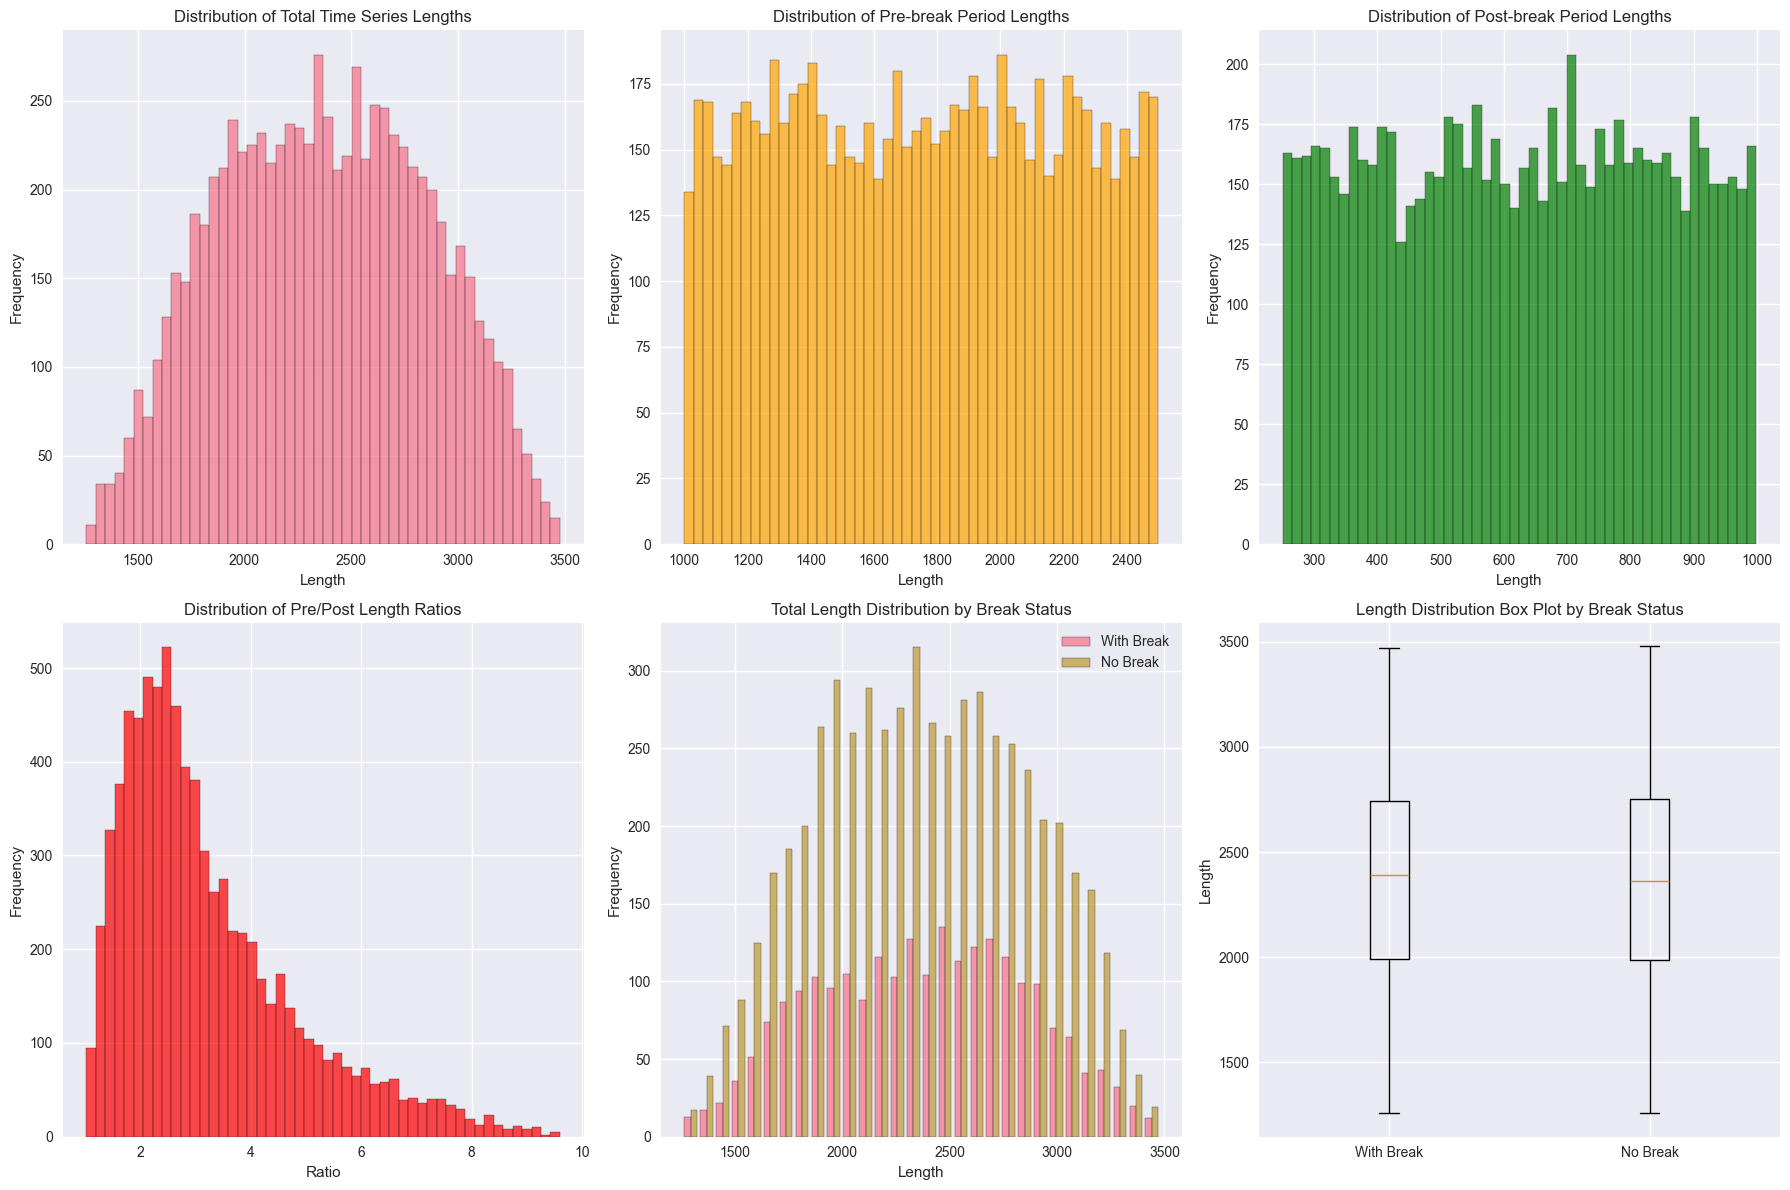

In [10]:
# 3. VISUALIZATION OF LENGTH DISTRIBUTIONS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Total lengths
axes[0, 0].hist(stats_df['total_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution of Total Time Series Lengths')
axes[0, 0].set_xlabel('Length')
axes[0, 0].set_ylabel('Frequency')

# Pre-break lengths
axes[0, 1].hist(stats_df['pre_length'], bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_title('Distribution of Pre-break Period Lengths')
axes[0, 1].set_xlabel('Length')
axes[0, 1].set_ylabel('Frequency')

# Post-break lengths
axes[0, 2].hist(stats_df['post_length'], bins=50, alpha=0.7, edgecolor='black', color='green')
axes[0, 2].set_title('Distribution of Post-break Period Lengths')
axes[0, 2].set_xlabel('Length')
axes[0, 2].set_ylabel('Frequency')

# Pre/Post ratios
axes[1, 0].hist(finite_ratios, bins=50, alpha=0.7, edgecolor='black', color='red')
axes[1, 0].set_title('Distribution of Pre/Post Length Ratios')
axes[1, 0].set_xlabel('Ratio')
axes[1, 0].set_ylabel('Frequency')

# Length comparison by break status
break_lengths = stats_df[stats_df['has_break'] == True]['total_length']
no_break_lengths = stats_df[stats_df['has_break'] == False]['total_length']

axes[1, 1].hist([break_lengths, no_break_lengths], bins=30, alpha=0.7,
                label=['With Break', 'No Break'], edgecolor='black')
axes[1, 1].set_title('Total Length Distribution by Break Status')
axes[1, 1].set_xlabel('Length')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Box plot of lengths by break status
data_for_box = [break_lengths, no_break_lengths]
axes[1, 2].boxplot(data_for_box, labels=['With Break', 'No Break'])
axes[1, 2].set_title('Length Distribution Box Plot by Break Status')
axes[1, 2].set_ylabel('Length')

plt.tight_layout()
plt.show()

In [11]:
# 4. TIME SERIES VALUE STATISTICS
print("\n" + "=" * 60)
print("TIME SERIES VALUE ANALYSIS")
print("=" * 60)

# Overall value statistics
all_values = X_train['value']
print(f"Overall value statistics (n={len(all_values):,}):")
print(f"  Mean: {all_values.mean():.6f}")
print(f"  Median: {all_values.median():.6f}")
print(f"  Std: {all_values.std():.6f}")
print(f"  Min: {all_values.min():.6f}")
print(f"  Max: {all_values.max():.6f}")
print(f"  Skewness: {all_values.skew():.3f}")
print(f"  Kurtosis: {all_values.kurtosis():.3f}")

# Test for normality
stat, p_value = normaltest(all_values.dropna())
print(f"  Normality test p-value: {p_value:.2e}")

# Values by period
pre_values = X_train[X_train['period'] == 0]['value']
post_values = X_train[X_train['period'] == 1]['value']

print(f"\nPre-break period values:")
print(f"  Mean: {pre_values.mean():.6f}")
print(f"  Std: {pre_values.std():.6f}")

print(f"\nPost-break period values:")
print(f"  Mean: {post_values.mean():.6f}")
print(f"  Std: {post_values.std():.6f}")


TIME SERIES VALUE ANALYSIS
Overall value statistics (n=18,994,617):
  Mean: 0.000576
  Median: 0.000087
  Std: 0.105486
  Min: -2.284821
  Max: 412.500000
  Skewness: 3201.633
  Kurtosis: 12336635.985
  Normality test p-value: 0.00e+00

Pre-break period values:
  Mean: 0.000586
  Std: 0.121098

Post-break period values:
  Mean: 0.000547
  Std: 0.034815


In [12]:
# 5. PER-SERIES STATISTICS ANALYSIS
print("\n" + "=" * 60)
print("PER-SERIES STATISTICS ANALYSIS")
print("=" * 60)

# Calculate statistics for each series
series_value_stats = []

for series_id in X_train.index.get_level_values(0).unique():
    series_data = X_train.loc[series_id]

    values = series_data['value']
    pre_values = series_data[series_data['period'] == 0]['value']
    post_values = series_data[series_data['period'] == 1]['value']

    # Overall series stats
    mean_val = values.mean()
    std_val = values.std()

    # Pre/post stats
    pre_mean = pre_values.mean()
    pre_std = pre_values.std()
    post_mean = post_values.mean()
    post_std = post_values.std()

    # Differences
    mean_diff = post_mean - pre_mean
    std_diff = post_std - pre_std

    series_value_stats.append({
        'id': series_id,
        'overall_mean': mean_val,
        'overall_std': std_val,
        'pre_mean': pre_mean,
        'pre_std': pre_std,
        'post_mean': post_mean,
        'post_std': post_std,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'has_break': y_train[series_id]
    })

value_stats_df = pd.DataFrame(series_value_stats)

# Statistics of the statistics
print("Distribution of per-series means:")
print(f"  Mean: {value_stats_df['overall_mean'].mean():.6f}")
print(f"  Std: {value_stats_df['overall_mean'].std():.6f}")

print("\nDistribution of per-series standard deviations:")
print(f"  Mean: {value_stats_df['overall_std'].mean():.6f}")
print(f"  Std: {value_stats_df['overall_std'].std():.6f}")

print("\nDistribution of pre-post mean differences:")
print(f"  Mean: {value_stats_df['mean_diff'].mean():.6f}")
print(f"  Std: {value_stats_df['mean_diff'].std():.6f}")

print("\nDistribution of pre-post std differences:")
print(f"  Mean: {value_stats_df['std_diff'].mean():.6f}")
print(f"  Std: {value_stats_df['std_diff'].std():.6f}")


PER-SERIES STATISTICS ANALYSIS
Distribution of per-series means:
  Mean: 0.000579
  Std: 0.003626

Distribution of per-series standard deviations:
  Mean: 0.017799
  Std: 0.105221

Distribution of pre-post mean differences:
  Mean: -0.000005
  Std: 0.005577

Distribution of pre-post std differences:
  Mean: -0.002191
  Std: 0.116262


In [13]:
# 6. AUTOCORRELATION ANALYSIS
print("\n" + "=" * 60)
print("AUTOCORRELATION ANALYSIS")
print("=" * 60)

# Calculate autocorrelations for a sample of series (this can be computationally intensive)
sample_size = min(1000, len(y_train))  # Sample for efficiency
sample_ids = np.random.choice(y_train.index, sample_size, replace=False)

autocorr_stats = []
max_lags = 20

for series_id in sample_ids:
    series_data = X_train.loc[series_id]['value']

    if len(series_data) > max_lags + 1:
        autocorrs = [series_data.autocorr(lag=lag) for lag in range(1, max_lags + 1)]
        autocorrs = [ac for ac in autocorrs if not pd.isna(ac)]  # Remove NaN values

        if len(autocorrs) > 0:
            autocorr_stats.append({
                'id': series_id,
                'autocorrs': autocorrs,
                'lag_1': autocorrs[0] if len(autocorrs) > 0 else np.nan,
                'lag_2': autocorrs[1] if len(autocorrs) > 1 else np.nan,
                'lag_5': autocorrs[4] if len(autocorrs) > 4 else np.nan,
                'lag_10': autocorrs[9] if len(autocorrs) > 9 else np.nan,
                'has_break': y_train[series_id]
            })

autocorr_df = pd.DataFrame(autocorr_stats)

if len(autocorr_df) > 0:
    print(f"Autocorrelation analysis (based on {len(autocorr_df)} series):")

    for lag in [1, 2, 5, 10]:
        col = f'lag_{lag}'
        if col in autocorr_df.columns:
            values = autocorr_df[col].dropna()
            if len(values) > 0:
                print(f"  Lag {lag} autocorrelation:")
                print(f"    Mean: {values.mean():.3f}")
                print(f"    Std: {values.std():.3f}")
                print(f"    Min: {values.min():.3f}")
                print(f"    Max: {values.max():.3f}")


AUTOCORRELATION ANALYSIS
Autocorrelation analysis (based on 1000 series):
  Lag 1 autocorrelation:
    Mean: 0.007
    Std: 0.136
    Min: -0.487
    Max: 0.572
  Lag 2 autocorrelation:
    Mean: 0.009
    Std: 0.077
    Min: -0.153
    Max: 0.944
  Lag 5 autocorrelation:
    Mean: -0.005
    Std: 0.031
    Min: -0.197
    Max: 0.100
  Lag 10 autocorrelation:
    Mean: 0.002
    Std: 0.038
    Min: -0.091
    Max: 0.850


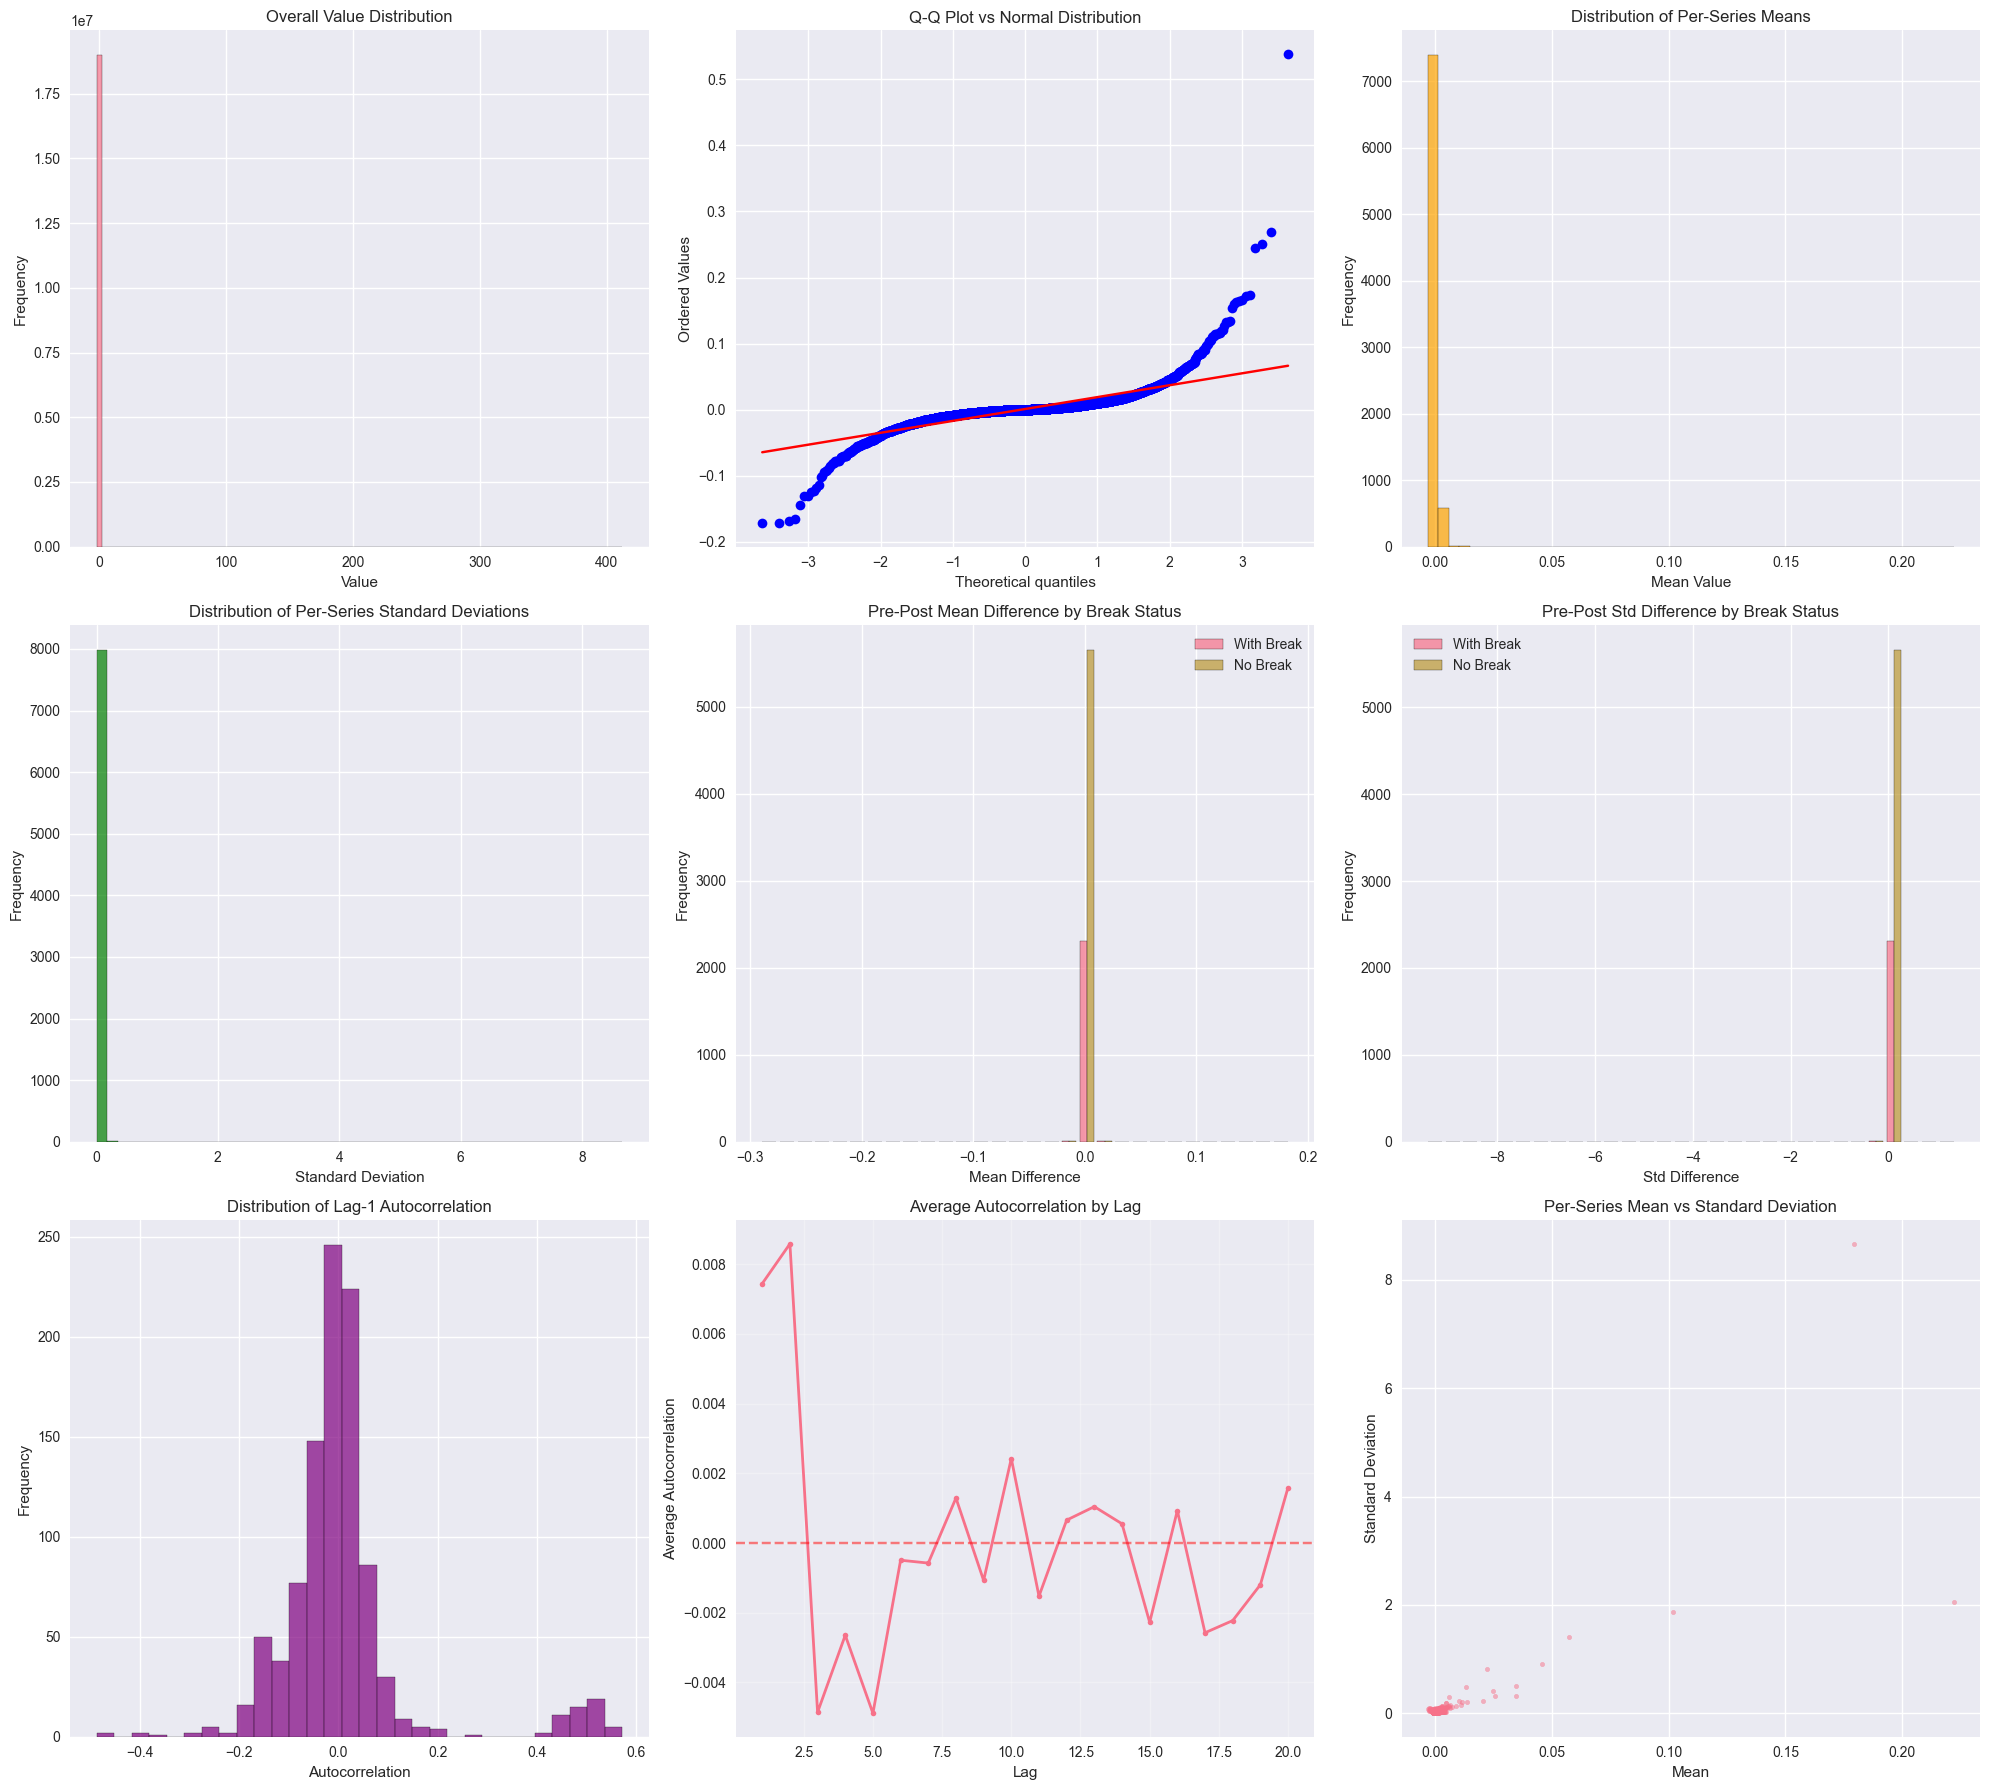

In [14]:
# 7. COMPREHENSIVE VISUALIZATIONS
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# Value distributions
axes[0, 0].hist(all_values, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Overall Value Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

# Q-Q plot for normality
stats.probplot(all_values.sample(5000), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot vs Normal Distribution')

# Per-series mean distribution
axes[0, 2].hist(value_stats_df['overall_mean'], bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[0, 2].set_title('Distribution of Per-Series Means')
axes[0, 2].set_xlabel('Mean Value')
axes[0, 2].set_ylabel('Frequency')

# Per-series std distribution
axes[1, 0].hist(value_stats_df['overall_std'], bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].set_title('Distribution of Per-Series Standard Deviations')
axes[1, 0].set_xlabel('Standard Deviation')
axes[1, 0].set_ylabel('Frequency')

# Mean difference by break status
break_mean_diffs = value_stats_df[value_stats_df['has_break'] == True]['mean_diff']
no_break_mean_diffs = value_stats_df[value_stats_df['has_break'] == False]['mean_diff']

axes[1, 1].hist([break_mean_diffs, no_break_mean_diffs], bins=30, alpha=0.7,
                label=['With Break', 'No Break'], edgecolor='black')
axes[1, 1].set_title('Pre-Post Mean Difference by Break Status')
axes[1, 1].set_xlabel('Mean Difference')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Std difference by break status
break_std_diffs = value_stats_df[value_stats_df['has_break'] == True]['std_diff']
no_break_std_diffs = value_stats_df[value_stats_df['has_break'] == False]['std_diff']

axes[1, 2].hist([break_std_diffs, no_break_std_diffs], bins=30, alpha=0.7,
                label=['With Break', 'No Break'], edgecolor='black')
axes[1, 2].set_title('Pre-Post Std Difference by Break Status')
axes[1, 2].set_xlabel('Std Difference')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

# Autocorrelation distributions
if len(autocorr_df) > 0:
    lag1_values = autocorr_df['lag_1'].dropna()
    if len(lag1_values) > 0:
        axes[2, 0].hist(lag1_values, bins=30, alpha=0.7, edgecolor='black', color='purple')
        axes[2, 0].set_title('Distribution of Lag-1 Autocorrelation')
        axes[2, 0].set_xlabel('Autocorrelation')
        axes[2, 0].set_ylabel('Frequency')

    # Average autocorrelation by lag
    if len(autocorr_df) > 0:
        avg_autocorrs = []
        for lag in range(1, max_lags + 1):
            lag_values = [ac[lag - 1] for ac in autocorr_df['autocorrs']
                          if len(ac) >= lag and not np.isnan(ac[lag - 1])]
            if len(lag_values) > 0:
                avg_autocorrs.append(np.mean(lag_values))
            else:
                avg_autocorrs.append(np.nan)

        lags = range(1, len(avg_autocorrs) + 1)
        axes[2, 1].plot(lags, avg_autocorrs, 'o-', linewidth=2, markersize=4)
        axes[2, 1].set_title('Average Autocorrelation by Lag')
        axes[2, 1].set_xlabel('Lag')
        axes[2, 1].set_ylabel('Average Autocorrelation')
        axes[2, 1].grid(True, alpha=0.3)
        axes[2, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)

# Scatter plot: mean vs std
axes[2, 2].scatter(value_stats_df['overall_mean'], value_stats_df['overall_std'],
                   alpha=0.5, s=10)
axes[2, 2].set_title('Per-Series Mean vs Standard Deviation')
axes[2, 2].set_xlabel('Mean')
axes[2, 2].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()

In [15]:
# 8. BREAK vs NO-BREAK COMPARATIVE ANALYSIS
print("\n" + "=" * 60)
print("BREAK vs NO-BREAK COMPARATIVE ANALYSIS")
print("=" * 60)

# Separate statistics by break status
break_stats = value_stats_df[value_stats_df['has_break'] == True]
no_break_stats = value_stats_df[value_stats_df['has_break'] == False]

print("SERIES WITH BREAKS:")
print(f"  Count: {len(break_stats)}")
print(f"  Mean of means: {break_stats['overall_mean'].mean():.6f}")
print(f"  Mean of stds: {break_stats['overall_std'].mean():.6f}")
print(f"  Mean of mean_diff: {break_stats['mean_diff'].mean():.6f}")
print(f"  Mean of std_diff: {break_stats['std_diff'].mean():.6f}")

print("\nSERIES WITHOUT BREAKS:")
print(f"  Count: {len(no_break_stats)}")
print(f"  Mean of means: {no_break_stats['overall_mean'].mean():.6f}")
print(f"  Mean of stds: {no_break_stats['overall_std'].mean():.6f}")
print(f"  Mean of mean_diff: {no_break_stats['mean_diff'].mean():.6f}")
print(f"  Mean of std_diff: {no_break_stats['std_diff'].mean():.6f}")

# Statistical tests
from scipy.stats import ttest_ind

print("\nSTATISTICAL TESTS (t-test p-values):")
_, p_mean_diff = ttest_ind(break_stats['mean_diff'], no_break_stats['mean_diff'])
_, p_std_diff = ttest_ind(break_stats['std_diff'], no_break_stats['std_diff'])
_, p_overall_mean = ttest_ind(break_stats['overall_mean'], no_break_stats['overall_mean'])
_, p_overall_std = ttest_ind(break_stats['overall_std'], no_break_stats['overall_std'])

print(f"  Mean difference: {p_mean_diff:.2e}")
print(f"  Std difference: {p_std_diff:.2e}")
print(f"  Overall mean: {p_overall_mean:.2e}")
print(f"  Overall std: {p_overall_std:.2e}")


BREAK vs NO-BREAK COMPARATIVE ANALYSIS
SERIES WITH BREAKS:
  Count: 2328
  Mean of means: 0.000627
  Mean of stds: 0.017988
  Mean of mean_diff: -0.000077
  Mean of std_diff: -0.002197

SERIES WITHOUT BREAKS:
  Count: 5674
  Mean of means: 0.000558
  Mean of stds: 0.017722
  Mean of mean_diff: 0.000024
  Mean of std_diff: -0.002188

STATISTICAL TESTS (t-test p-values):
  Mean difference: 4.61e-01
  Std difference: 9.97e-01
  Overall mean: 4.40e-01
  Overall std: 9.18e-01



SAMPLE TIME SERIES VISUALIZATION


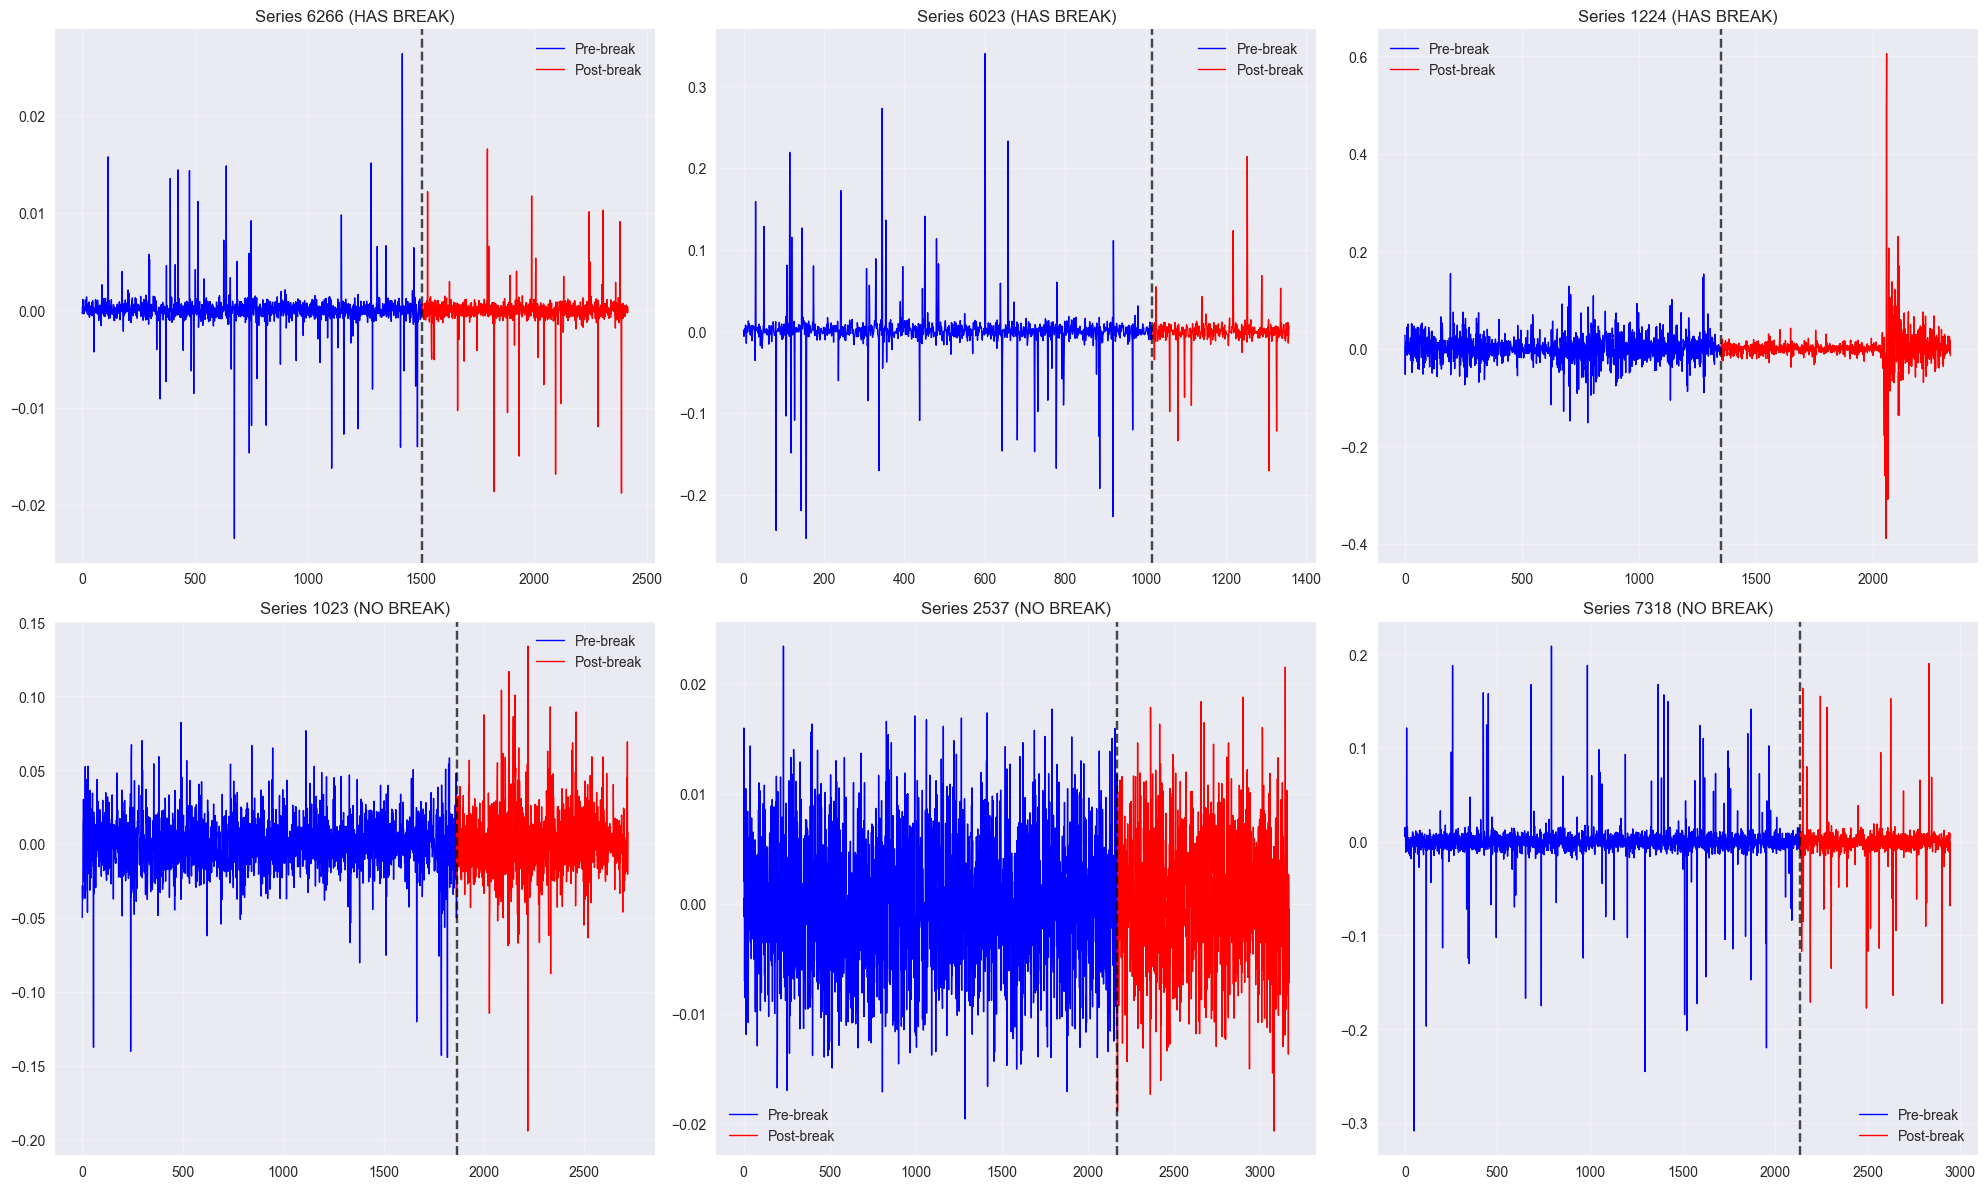

In [16]:
# 9. SAMPLE TIME SERIES VISUALIZATION
print("\n" + "=" * 60)
print("SAMPLE TIME SERIES VISUALIZATION")
print("=" * 60)

# Plot sample time series
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Get sample series
break_ids = y_train[y_train == True].index[:3]
no_break_ids = y_train[y_train == False].index[:3]

for i, series_id in enumerate(break_ids):
    series_data = X_train.loc[series_id]

    # Split by period
    pre_data = series_data[series_data['period'] == 0]
    post_data = series_data[series_data['period'] == 1]

    axes[0, i].plot(range(len(pre_data)), pre_data['value'], 'b-', label='Pre-break', linewidth=1)
    axes[0, i].plot(range(len(pre_data), len(pre_data) + len(post_data)),
                    post_data['value'], 'r-', label='Post-break', linewidth=1)
    axes[0, i].axvline(x=len(pre_data), color='black', linestyle='--', alpha=0.7)
    axes[0, i].set_title(f'Series {series_id} (HAS BREAK)')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

for i, series_id in enumerate(no_break_ids):
    series_data = X_train.loc[series_id]

    # Split by period
    pre_data = series_data[series_data['period'] == 0]
    post_data = series_data[series_data['period'] == 1]

    axes[1, i].plot(range(len(pre_data)), pre_data['value'], 'b-', label='Pre-break', linewidth=1)
    axes[1, i].plot(range(len(pre_data), len(pre_data) + len(post_data)),
                    post_data['value'], 'r-', label='Post-break', linewidth=1)
    axes[1, i].axvline(x=len(pre_data), color='black', linestyle='--', alpha=0.7)
    axes[1, i].set_title(f'Series {series_id} (NO BREAK)')
    axes[1, i].legend()
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# 10. SUMMARY STATISTICS FOR SYNTHETIC DATA GENERATION
print("\n" + "=" * 60)
print("SUMMARY FOR SYNTHETIC DATA GENERATION")
print("=" * 60)

summary_stats = {
    'dataset_size': len(y_train),
    'break_ratio': y_train.mean(),

    # Length characteristics
    'total_length_mean': stats_df['total_length'].mean(),
    'total_length_std': stats_df['total_length'].std(),
    'total_length_min': stats_df['total_length'].min(),
    'total_length_max': stats_df['total_length'].max(),

    'pre_length_mean': stats_df['pre_length'].mean(),
    'pre_length_std': stats_df['pre_length'].std(),

    'post_length_mean': stats_df['post_length'].mean(),
    'post_length_std': stats_df['post_length'].std(),

    'pre_post_ratio_mean': finite_ratios.mean(),
    'pre_post_ratio_std': finite_ratios.std(),

    # Value characteristics
    'overall_value_mean': all_values.mean(),
    'overall_value_std': all_values.std(),

    'series_mean_mean': value_stats_df['overall_mean'].mean(),
    'series_mean_std': value_stats_df['overall_mean'].std(),

    'series_std_mean': value_stats_df['overall_std'].mean(),
    'series_std_std': value_stats_df['overall_std'].std(),

    # Break characteristics
    'break_mean_diff_mean': break_stats['mean_diff'].mean(),
    'break_mean_diff_std': break_stats['mean_diff'].std(),

    'break_std_diff_mean': break_stats['std_diff'].mean(),
    'break_std_diff_std': break_stats['std_diff'].std(),

    'no_break_mean_diff_mean': no_break_stats['mean_diff'].mean(),
    'no_break_mean_diff_std': no_break_stats['mean_diff'].std(),
}

print("Key statistics for synthetic data generation:")
for key, value in summary_stats.items():
    print(f"  {key}: {value:.6f}")

# Save summary statistics
import json

with open('dataset_characteristics.json', 'w') as f:
    json.dump({k: float(v) for k, v in summary_stats.items()}, f, indent=2)

print(f"\nSaved summary statistics to 'dataset_characteristics.json'")
print("Use these statistics to generate synthetic data with similar characteristics!")


SUMMARY FOR SYNTHETIC DATA GENERATION
Key statistics for synthetic data generation:
  dataset_size: 8002.000000
  break_ratio: 0.290927
  total_length_mean: 2373.733692
  total_length_std: 484.762230
  total_length_min: 1258.000000
  total_length_max: 3478.000000
  pre_length_mean: 1749.537866
  pre_length_std: 431.798183
  post_length_mean: 624.195826
  post_length_std: 215.854550
  pre_post_ratio_mean: 3.236347
  pre_post_ratio_std: 1.591141
  overall_value_mean: 0.000576
  overall_value_std: 0.105486
  series_mean_mean: 0.000579
  series_mean_std: 0.003626
  series_std_mean: 0.017799
  series_std_std: 0.105221
  break_mean_diff_mean: -0.000077
  break_mean_diff_std: 0.006527
  break_std_diff_mean: -0.002197
  break_std_diff_std: 0.066416
  no_break_mean_diff_mean: 0.000024
  no_break_mean_diff_std: 0.005138

Saved summary statistics to 'dataset_characteristics.json'
Use these statistics to generate synthetic data with similar characteristics!


In [66]:
train_data_dict = data_handler.get_first_n_train_series(10000)

In [94]:
from tqdm import tqdm
import pandas as pd
from statsmodels.tsa.stattools import pacf

stats = {}

for series_id, ts_obj in tqdm(train_data_dict.items()):
    pre = ts_obj.period_0_values
    post = ts_obj.period_1_values

    # PACF for pre and post
    pacf_pre = pacf(pre, nlags=10, method="ywadjusted")
    pacf_post = pacf(post, nlags=10, method="ywadjusted")

    # Base stats
    series_stats = {
        "break": ts_obj.has_break,
        "length_0": pre.shape[0],
        "length_1": post.shape[0],
        "mean_0": pre.mean(),
        "mean_1": post.mean(),
        "std_0": pre.std(),
        "std_1": post.std(),
    }

    # Add PACF lags for pre
    for lag, value in enumerate(pacf_pre):
        series_stats[f"pacf_pre_lag{lag}"] = value

    # Add PACF lags for post
    for lag, value in enumerate(pacf_post):
        series_stats[f"pacf_post_lag{lag}"] = value
    
    for lag, (value_pre, value_post) in enumerate(zip(pacf_pre,pacf_post)):
        series_stats[f"pacf_diff_lag{lag}"] = value_post - value_pre
        
    for lag, (value_pre, value_post) in enumerate(zip(pacf_pre,pacf_post)):
        series_stats[f"pacf_ratio_lag{lag}"] = (value_post - value_pre) / (np.sign(value_pre) * max(abs(value_pre), 0.1))


    stats[series_id] = series_stats
    
# convert nested dict → DataFrame
df = pd.DataFrame.from_dict(stats, orient="index")
df.index.name = "series_id"

df.head()

100%|██████████| 10000/10000 [00:10<00:00, 989.37it/s]


,break,length_0,length_1,mean_0,mean_1,std_0,std_1,pacf_pre_lag0,pacf_pre_lag1,pacf_pre_lag2,...,pacf_ratio_lag1,pacf_ratio_lag2,pacf_ratio_lag3,pacf_ratio_lag4,pacf_ratio_lag5,pacf_ratio_lag6,pacf_ratio_lag7,pacf_ratio_lag8,pacf_ratio_lag9,pacf_ratio_lag10
series_id,,,,,,,,,,,,,,,,,,,,,
0,False,1351,294,0.000015,0.000006,0.006985,0.006865,1.0,-0.156063,-0.153793,...,-0.409753,-0.537303,0.104537,0.580369,0.043841,0.284310,-0.084354,0.200328,0.592703,0.781514
1,False,2247,282,0.000128,-0.000090,0.002524,0.002032,1.0,0.048864,-0.075441,...,-1.794292,0.313113,-1.028749,-0.770743,0.532168,-0.838171,-1.352528,0.005183,0.833209,-0.449610
2,True,2333,515,0.000389,0.001790,0.017218,0.022877,1.0,-0.107284,-0.008178,...,0.615417,0.466794,0.127479,-1.677278,-1.014337,-0.687738,-0.382669,0.505247,-1.036696,-1.239573
3,False,2271,629,0.000381,0.000326,0.008386,0.009278,1.0,-0.014060,-0.011744,...,-0.659549,-0.454038,-0.403746,-0.318996,0.007807,0.137579,-0.212599,-0.705303,-0.027134,0.295964
4,False,1657,456,-0.000016,0.000024,0.003313,0.003404,1.0,0.532265,0.042175,...,0.053394,-0.320113,-1.715453,-0.752773,-0.148802,-0.171076,-0.860874,-0.409586,-0.283354,0.140420


In [150]:
import statsmodels.api as sm

# Define predictor (lag-1) and target (lag-2)
X = df["pacf_pre_lag2"]
y = df["pacf_pre_lag3"]

# Add constant term for intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          pacf_pre_lag3   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     2094.
Date:                Wed, 27 Aug 2025   Prob (F-statistic):               0.00
Time:                        20:39:41   Log-Likelihood:                 18725.
No. Observations:               10000   AIC:                        -3.745e+04
Df Residuals:                    9998   BIC:                        -3.743e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0077      0.000    -19.543

In [153]:
np.corrcoef(df["pacf_pre_lag4"], df["pacf_pre_lag3"])

array([[1.       , 0.3785784],
       [0.3785784, 1.       ]])

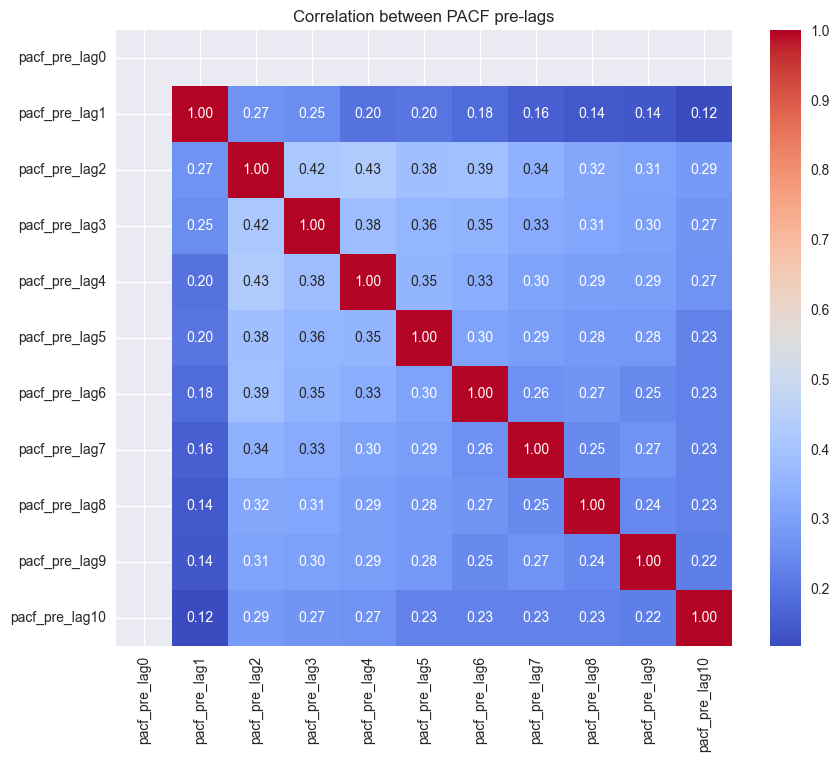

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the pre-lag columns
pre_lag_cols = [col for col in df.columns if col.startswith("pacf_pre_lag")]
df_pre_lags = df[pre_lag_cols]

# Compute correlation
corr_matrix = df_pre_lags.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation between PACF pre-lags")
plt.show()


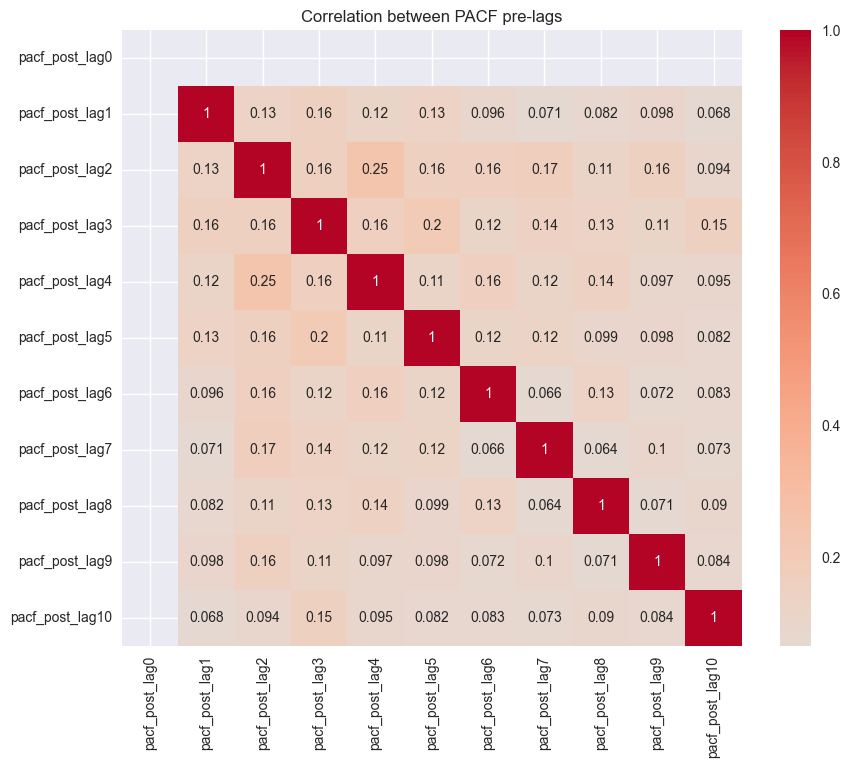

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the PACF pre-lag columns
pre_lag_cols = [col for col in df.columns if col.startswith("pacf_post_lag")]
df_pre_lags = df[pre_lag_cols]

# Compute correlation matrix
corr_matrix = df_pre_lags.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between PACF pre-lags")
plt.show()


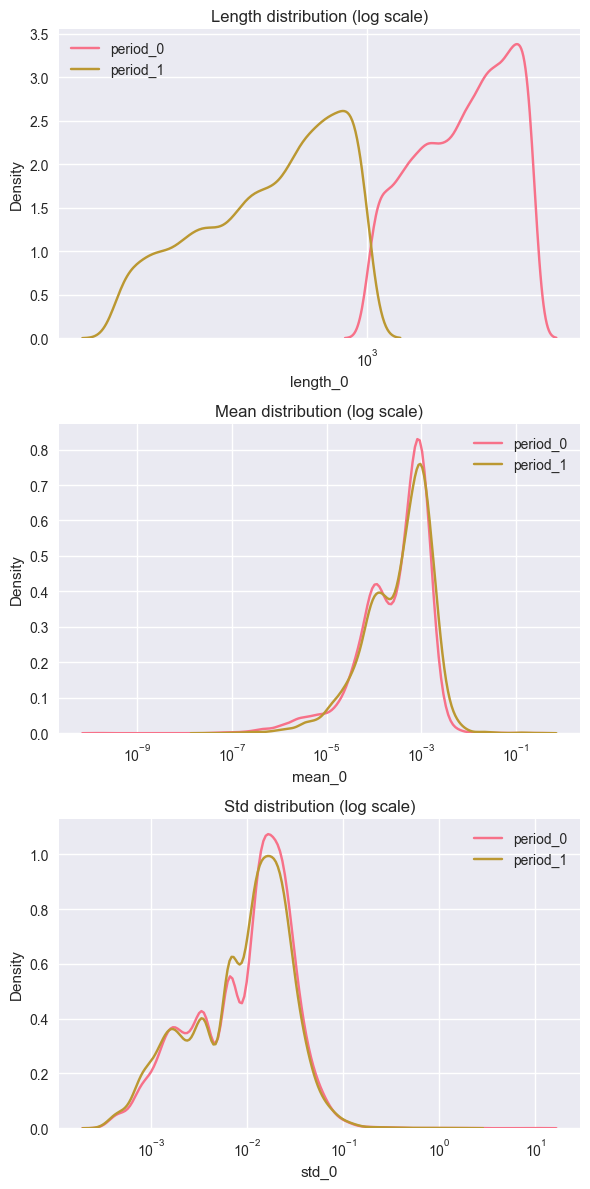

In [95]:
fig, axes = plt.subplots(3, 1, figsize=(6, 12), sharex=False)

# Length distributions
sns.kdeplot(df["length_0"], label="period_0", ax=axes[0], log_scale=10)
sns.kdeplot(df["length_1"], label="period_1", ax=axes[0], log_scale=10)
axes[0].set_title("Length distribution (log scale)")
# axes[0].set_xscale("log")
axes[0].legend()

# Mean distributions
sns.kdeplot(df["mean_0"], label="period_0", ax=axes[1], log_scale=10)
sns.kdeplot(df["mean_1"], label="period_1", ax=axes[1], log_scale=10)
axes[1].set_title("Mean distribution (log scale)")
# axes[1].set_xscale("log")
axes[1].legend()

# Std distributions
sns.kdeplot(df["std_0"], label="period_0", ax=axes[2], log_scale=10)
sns.kdeplot(df["std_1"], label="period_1", ax=axes[2], log_scale=10)
axes[2].set_title("Std distribution (log scale)")
# axes[2].set_xscale("log")
axes[2].legend()

plt.tight_layout()
plt.show()


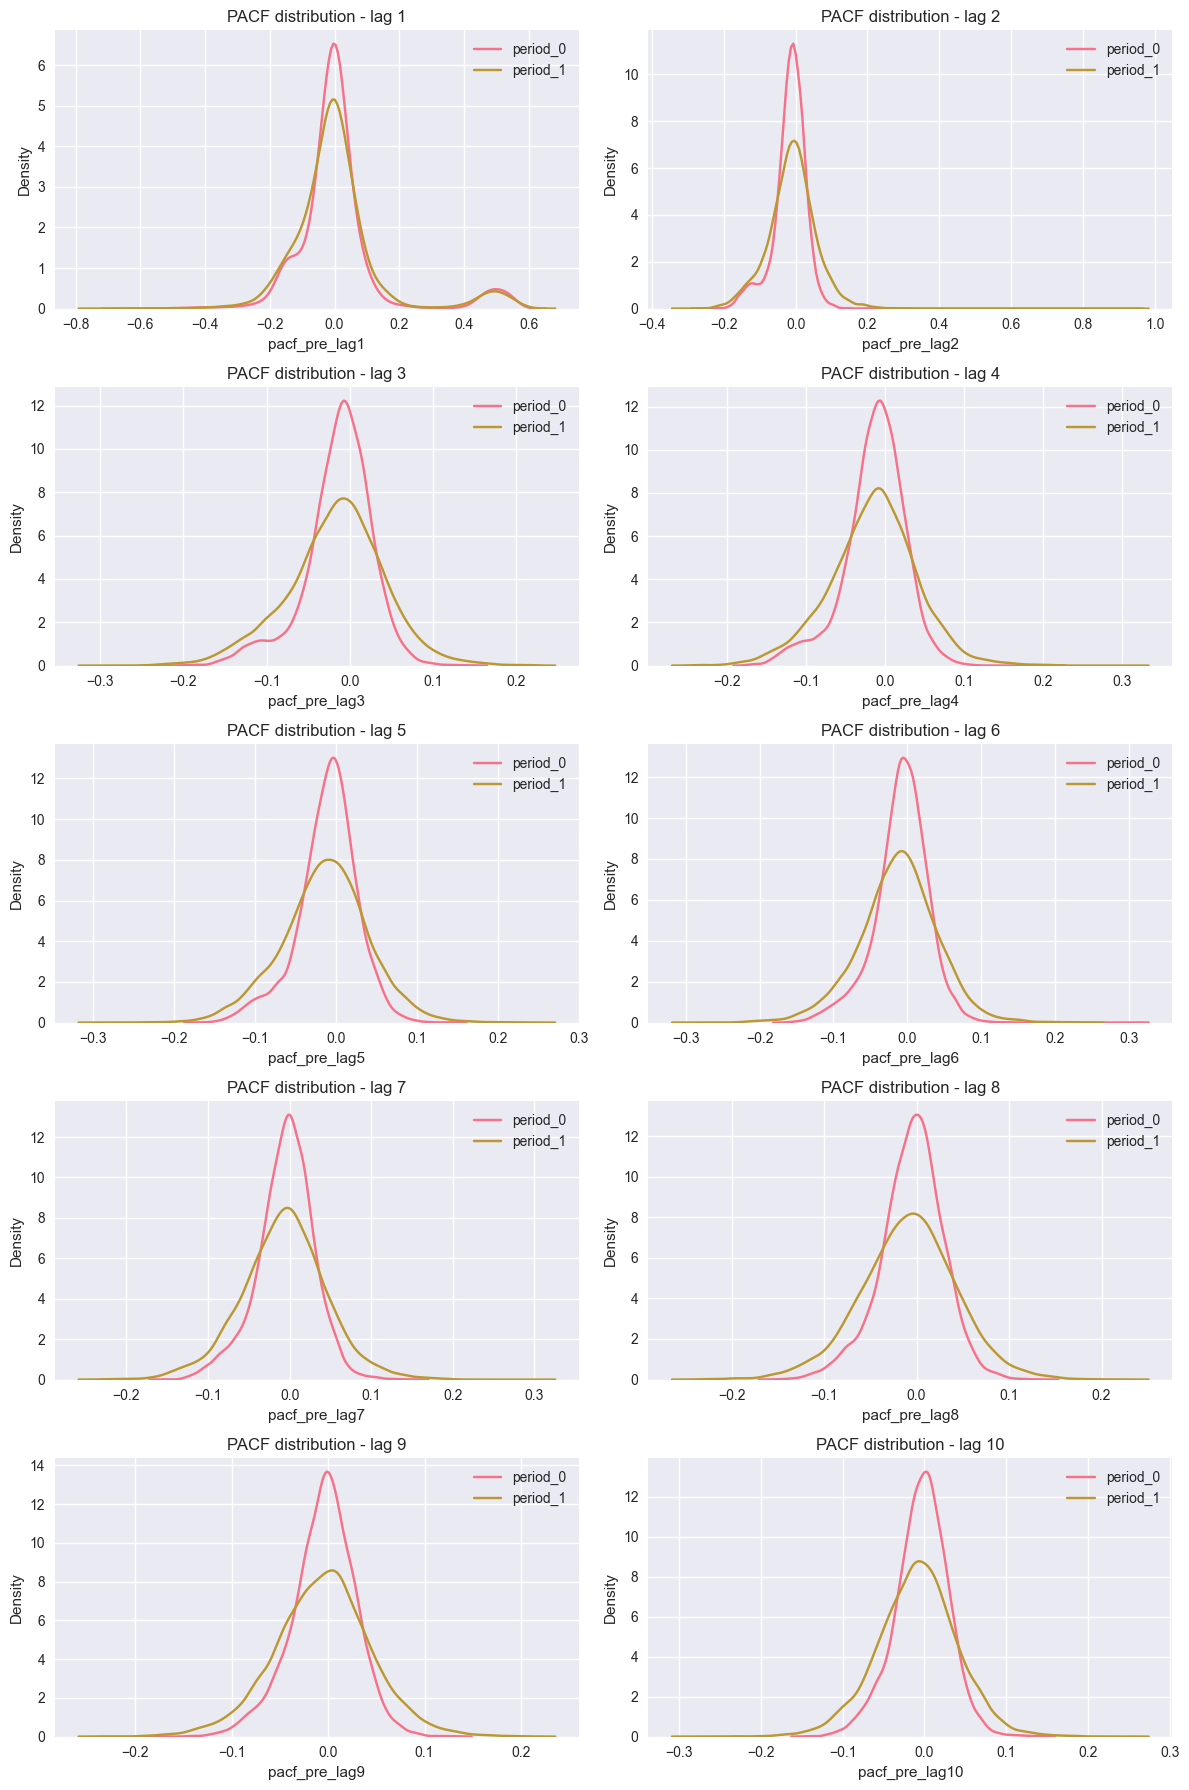

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# PACF lags to plot (1–10)
lags = range(1, 11)

fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=False)
axes = axes.flatten()

for i, lag in enumerate(lags):
    sns.kdeplot(df[f"pacf_pre_lag{lag}"], label="period_0", ax=axes[i])
    sns.kdeplot(df[f"pacf_post_lag{lag}"], label="period_1", ax=axes[i])
    axes[i].set_title(f"PACF distribution - lag {lag}")
    axes[i].legend()

plt.tight_layout()
plt.show()


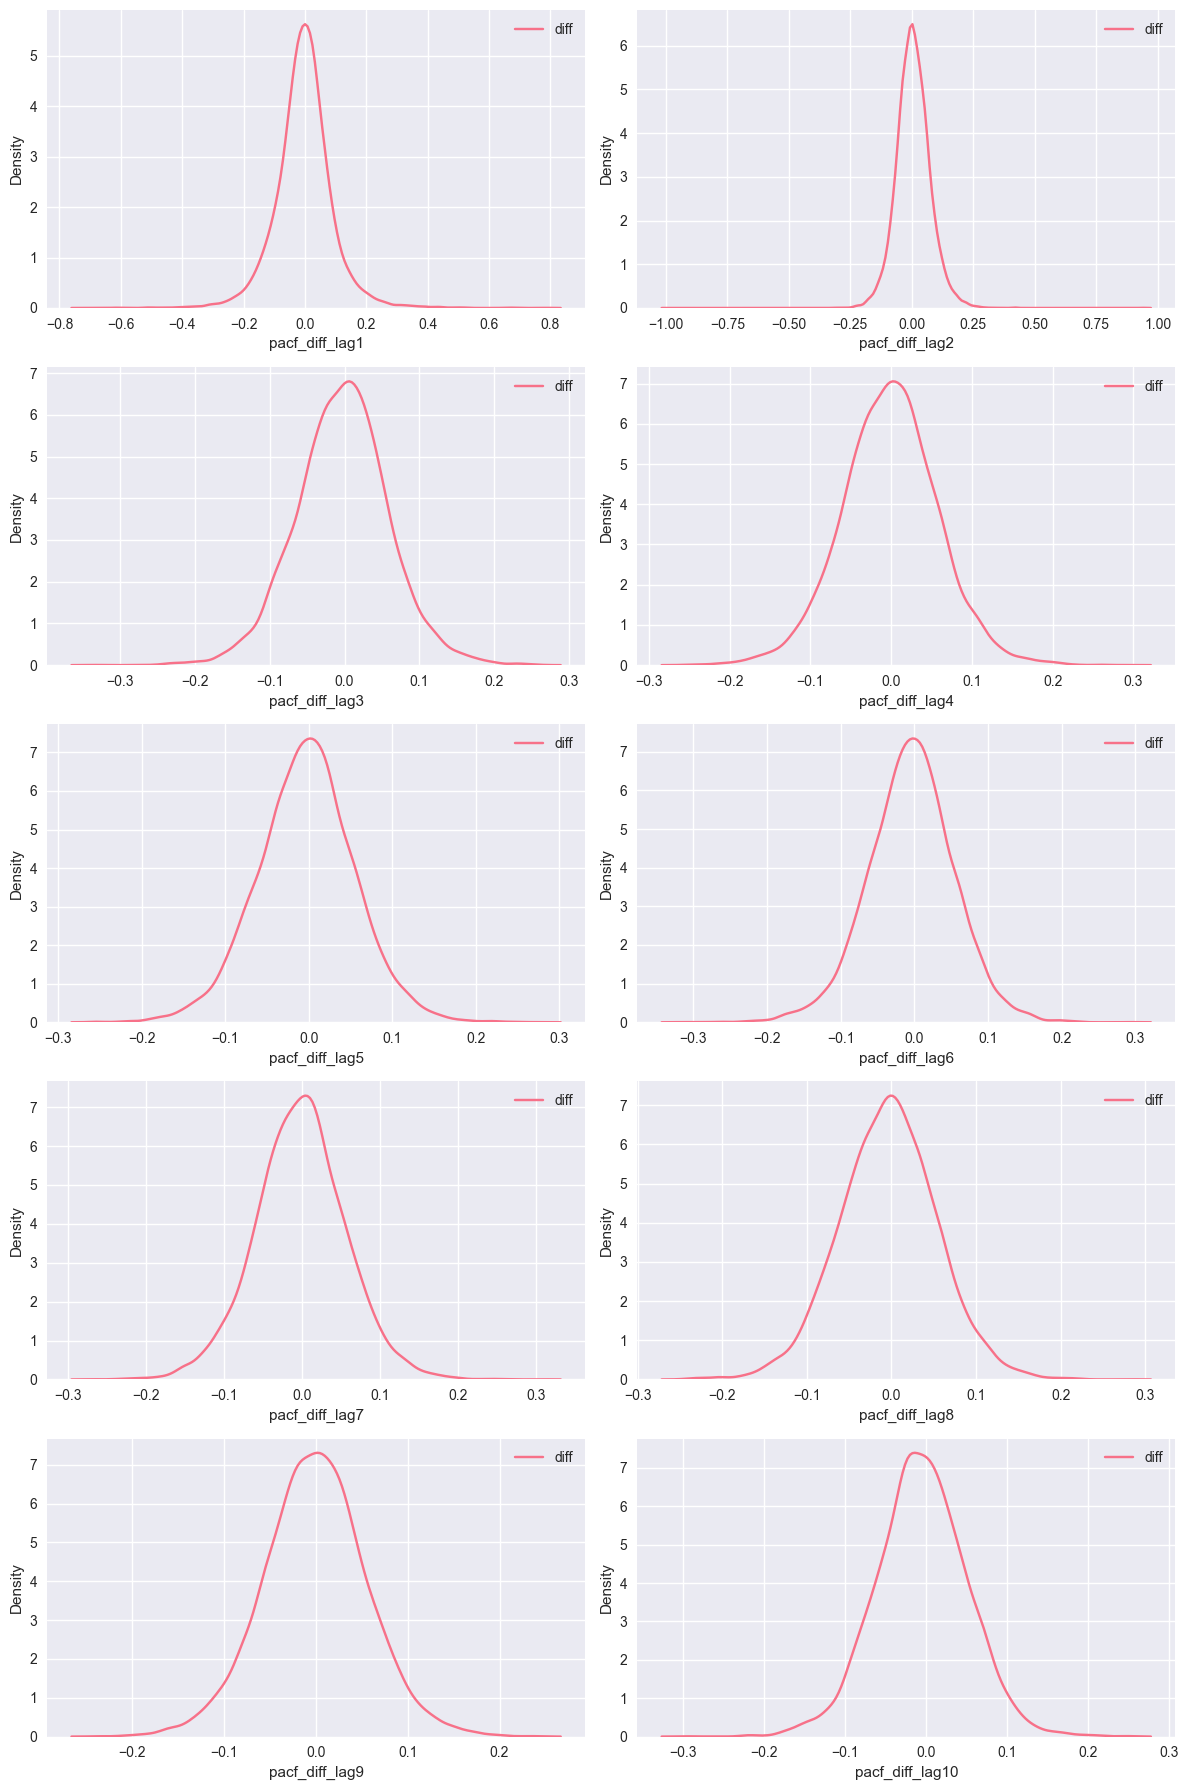

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# PACF lags to plot (1–10)
lags = range(1, 11)

fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=False)
axes = axes.flatten()

for i, lag in enumerate(lags):
    sns.kdeplot(df[f"pacf_diff_lag{lag}"], label="diff", ax=axes[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

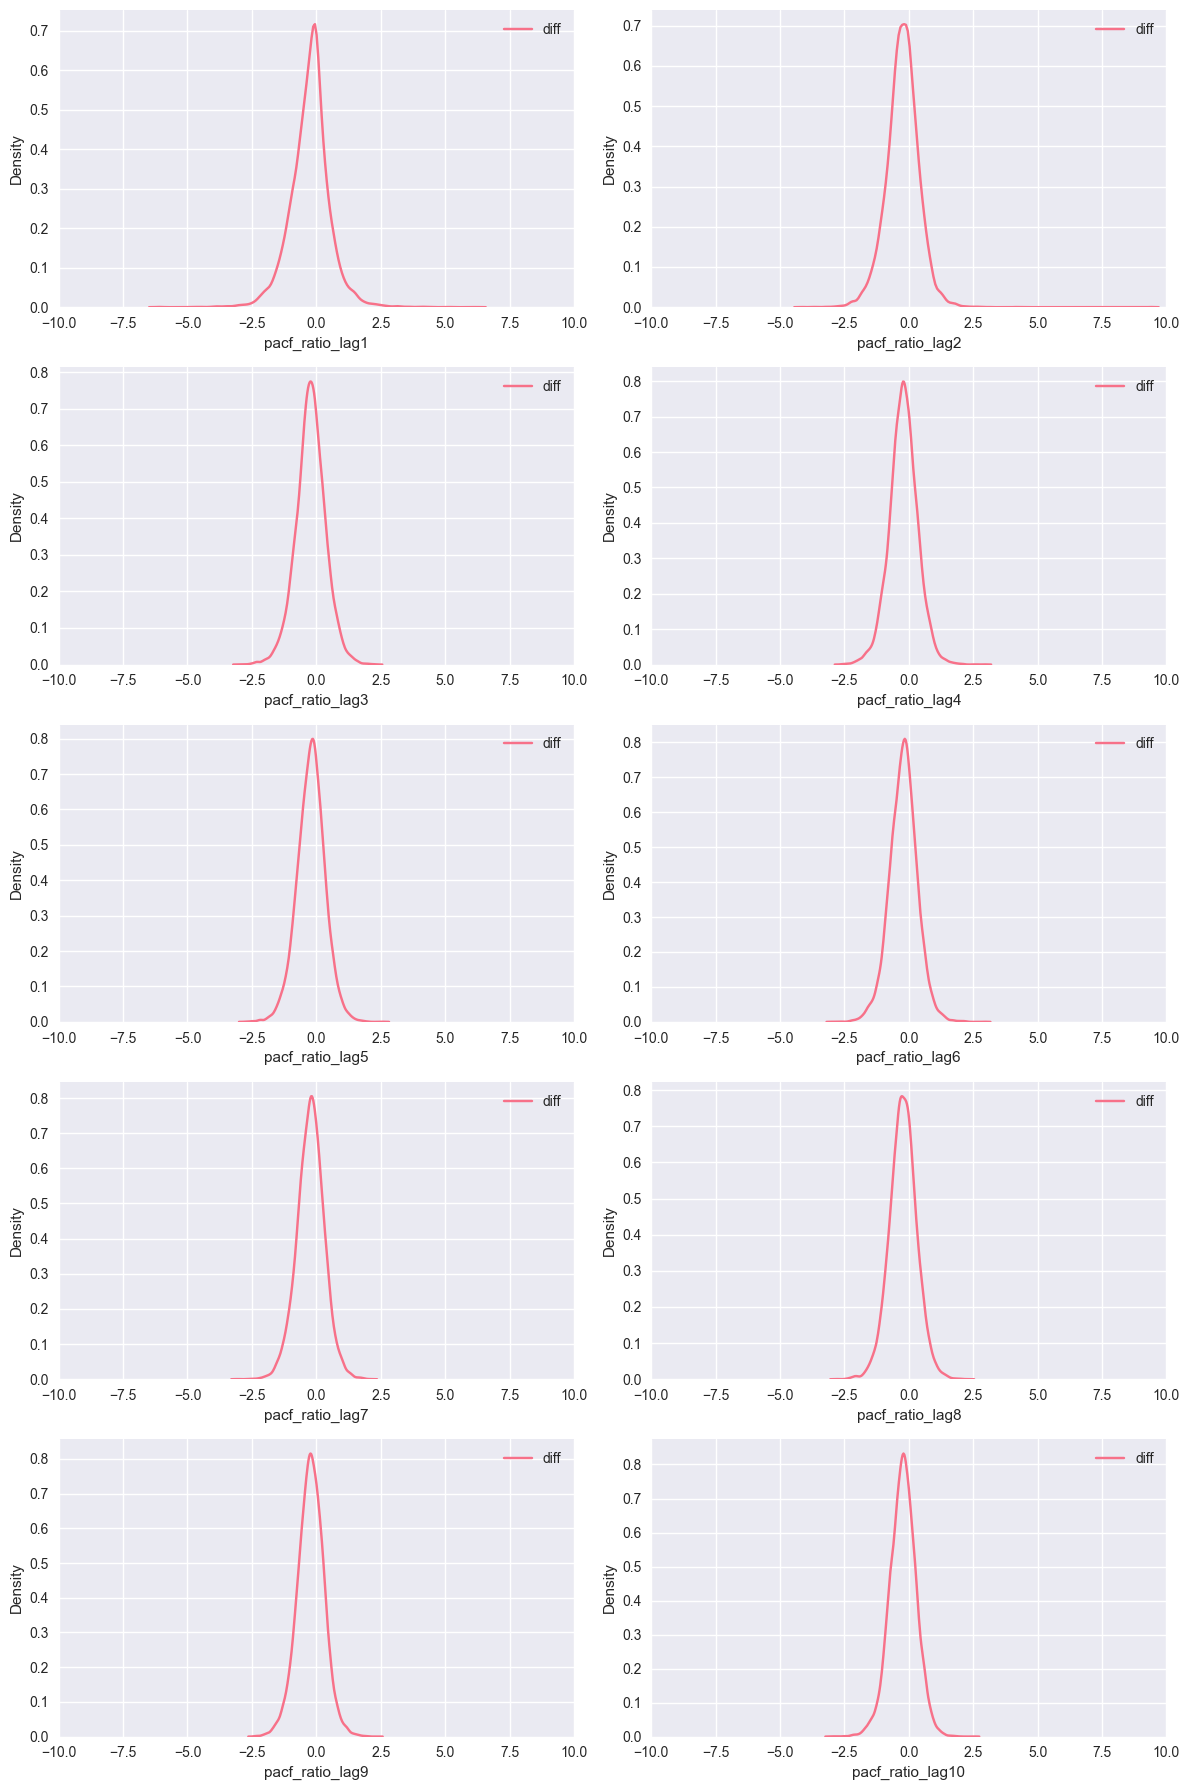

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

# PACF lags to plot (1–10)
lags = range(1, 11)

fig, axes = plt.subplots(5, 2, figsize=(12, 18), sharex=False)
axes = axes.flatten()

for i, lag in enumerate(lags):
    sns.kdeplot(df[f"pacf_ratio_lag{lag}"], label="diff", ax=axes[i])
    axes[i].set_xlim(-10, 10)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [99]:
df.describe()

,length_0,length_1,mean_0,mean_1,std_0,std_1,pacf_pre_lag0,pacf_pre_lag1,pacf_pre_lag2,pacf_pre_lag3,...,pacf_ratio_lag1,pacf_ratio_lag2,pacf_ratio_lag3,pacf_ratio_lag4,pacf_ratio_lag5,pacf_ratio_lag6,pacf_ratio_lag7,pacf_ratio_lag8,pacf_ratio_lag9,pacf_ratio_lag10
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1746.739700,624.619800,0.000569,0.000597,0.017377,0.015575,1.0,0.012403,-0.016116,-0.013537,...,-0.245049,-0.241606,-0.218648,-0.209242,-0.204169,-0.210962,-0.221897,-0.223680,-0.219152,-0.230478
std,432.528977,215.987352,0.004004,0.004513,0.103173,0.031020,0.0,0.143351,0.046904,0.040911,...,0.775546,0.637214,0.577325,0.552321,0.544056,0.544681,0.536154,0.533955,0.519674,0.517096
min,1000.000000,250.000000,-0.004039,-0.011972,0.000337,0.000341,1.0,-0.652240,-0.268641,-0.227709,...,-6.120171,-4.142928,-2.951441,-2.610748,-2.741614,-2.933028,-3.045496,-2.792328,-2.391640,-2.991927
25%,1368.000000,435.000000,0.000036,0.000007,0.003714,0.003656,1.0,-0.044500,-0.036051,-0.032791,...,-0.659824,-0.606135,-0.562435,-0.548272,-0.546688,-0.556414,-0.558751,-0.560182,-0.545600,-0.555768
50%,1749.000000,629.000000,0.000258,0.000213,0.012905,0.011581,1.0,-0.003541,-0.010662,-0.008925,...,-0.197703,-0.227736,-0.213747,-0.209395,-0.191630,-0.200896,-0.210765,-0.223055,-0.212053,-0.220261
75%,2119.250000,810.000000,0.000825,0.000870,0.021804,0.020481,1.0,0.033863,0.012225,0.012512,...,0.157963,0.142925,0.142166,0.132688,0.141803,0.129725,0.116419,0.113026,0.120144,0.102324
max,2499.000000,999.000000,0.291075,0.318223,9.503665,1.636797,1.0,0.583224,0.945350,0.145712,...,6.209298,9.395671,2.286771,2.932772,2.564828,2.908880,2.102536,2.282362,2.329370,2.489653


In [110]:
df['pacf_pre_lag1'].skew()

np.float64(1.908050191610292)

In [113]:
df['pacf_pre_lag1'].kurtosis()

np.float64(5.7916900876647865)

In [103]:
df[df["break"] == True].describe()

,length_0,length_1,mean_0,mean_1,std_0,std_1,pacf_pre_lag0,pacf_pre_lag1,pacf_pre_lag2,pacf_pre_lag3,...,pacf_ratio_lag1,pacf_ratio_lag2,pacf_ratio_lag3,pacf_ratio_lag4,pacf_ratio_lag5,pacf_ratio_lag6,pacf_ratio_lag7,pacf_ratio_lag8,pacf_ratio_lag9,pacf_ratio_lag10
count,2908.000000,2908.00000,2908.000000,2908.000000,2908.000000,2908.000000,2908.0,2908.000000,2908.000000,2908.000000,...,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000,2908.000000
mean,1749.454608,622.39718,0.000631,0.000577,0.017706,0.015813,1.0,0.013113,-0.014942,-0.012871,...,-0.306804,-0.238872,-0.220753,-0.206713,-0.204350,-0.214864,-0.218045,-0.233575,-0.219968,-0.243762
std,432.717111,214.75289,0.005695,0.001600,0.059440,0.019414,0.0,0.144517,0.049394,0.041154,...,0.871823,0.628693,0.582435,0.545632,0.539795,0.537227,0.540943,0.527138,0.529069,0.515947
min,1000.000000,250.00000,-0.003234,-0.007119,0.000372,0.000362,1.0,-0.596180,-0.224531,-0.197477,...,-6.120171,-3.282810,-2.531304,-2.461604,-2.326576,-2.697808,-2.554893,-2.792328,-2.142907,-2.265003
25%,1372.000000,430.00000,0.000029,0.000003,0.003617,0.003608,1.0,-0.044494,-0.036307,-0.031958,...,-0.766527,-0.606009,-0.566860,-0.532448,-0.539629,-0.552390,-0.553476,-0.559187,-0.538274,-0.584638
50%,1760.500000,629.50000,0.000226,0.000203,0.013411,0.011857,1.0,-0.003874,-0.009499,-0.008566,...,-0.231784,-0.210994,-0.219926,-0.208682,-0.196474,-0.200769,-0.199116,-0.228062,-0.202744,-0.237593
75%,2119.000000,802.00000,0.000804,0.000909,0.022140,0.022174,1.0,0.034901,0.012696,0.013113,...,0.144663,0.152350,0.132296,0.120712,0.143109,0.115436,0.133759,0.078918,0.129611,0.094597
max,2499.000000,999.00000,0.291075,0.034204,2.349049,0.378586,1.0,0.583224,0.945350,0.122581,...,6.209298,2.736970,1.981966,2.607874,1.846301,1.902091,2.102536,1.928769,1.764096,1.779192


In [104]:
df[df["break"] == False].describe()

,length_0,length_1,mean_0,mean_1,std_0,std_1,pacf_pre_lag0,pacf_pre_lag1,pacf_pre_lag2,pacf_pre_lag3,...,pacf_ratio_lag1,pacf_ratio_lag2,pacf_ratio_lag3,pacf_ratio_lag4,pacf_ratio_lag5,pacf_ratio_lag6,pacf_ratio_lag7,pacf_ratio_lag8,pacf_ratio_lag9,pacf_ratio_lag10
count,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.0,7092.000000,7092.000000,7092.000000,...,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000,7092.000000
mean,1745.626481,625.531162,0.000543,0.000605,0.017242,0.015477,1.0,0.012112,-0.016597,-0.013810,...,-0.219727,-0.242727,-0.217785,-0.210279,-0.204094,-0.209361,-0.223477,-0.219622,-0.218818,-0.225031
std,432.477402,216.499990,0.003051,0.005260,0.116454,0.034675,0.0,0.142880,0.045838,0.040811,...,0.730980,0.640715,0.575255,0.555075,0.545831,0.547738,0.534208,0.536709,0.515809,0.517505
min,1000.000000,250.000000,-0.004039,-0.011972,0.000337,0.000341,1.0,-0.652240,-0.268641,-0.227709,...,-4.886973,-4.142928,-2.951441,-2.610748,-2.741614,-2.933028,-3.045496,-2.441178,-2.391640,-2.991927
25%,1366.750000,437.000000,0.000039,0.000009,0.003750,0.003683,1.0,-0.044508,-0.035951,-0.033167,...,-0.622370,-0.606328,-0.562163,-0.551336,-0.549540,-0.558105,-0.561798,-0.560812,-0.546641,-0.541505
50%,1743.000000,629.000000,0.000271,0.000219,0.012700,0.011522,1.0,-0.003393,-0.011192,-0.009089,...,-0.182146,-0.233653,-0.210391,-0.209537,-0.189086,-0.201025,-0.216014,-0.220474,-0.216060,-0.214233
75%,2120.000000,812.000000,0.000836,0.000853,0.021649,0.019850,1.0,0.033248,0.012011,0.012301,...,0.161800,0.138875,0.145211,0.137529,0.140848,0.131816,0.109503,0.125716,0.115954,0.105791
max,2499.000000,999.000000,0.216618,0.318223,9.503665,1.636797,1.0,0.581835,0.263211,0.145712,...,4.089366,9.395671,2.286771,2.932772,2.564828,2.908880,1.909880,2.282362,2.329370,2.489653


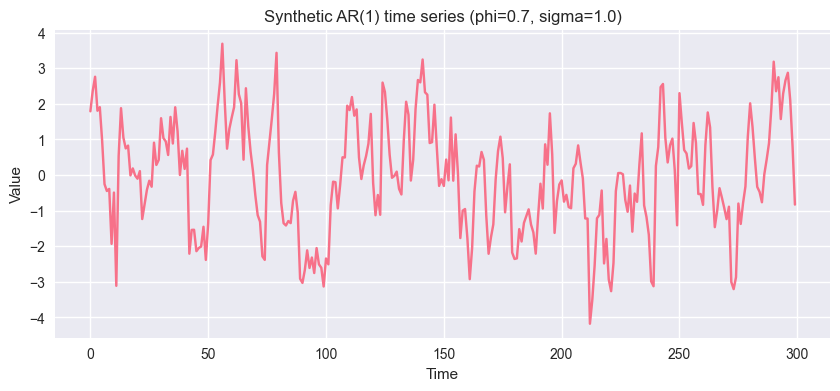

In [106]:
def generate_ar1(phi=0.8, sigma=1.0, n=200, burnin=50):
    """
    Generate a synthetic AR(1) time series.

    Parameters:
        phi (float): AR(1) coefficient
        sigma (float): standard deviation of noise
        n (int): length of output time series
        burnin (int): number of initial steps to discard (to reduce start-up bias)

    Returns:
        np.ndarray: AR(1) time series
    """
    # noise
    eps = np.random.normal(0, sigma, n + burnin)
    
    # allocate array
    x = np.zeros(n + burnin)
    
    # simulate AR(1)
    for t in range(1, n + burnin):
        x[t] = phi * x[t-1] + eps[t]
    
    return x[burnin:]  # discard burn-in

# Example usage
ts = generate_ar1(phi=0.7, sigma=1.0, n=300)

plt.figure(figsize=(10, 4))
plt.plot(ts)
plt.title("Synthetic AR(1) time series (phi=0.7, sigma=1.0)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [175]:
train_data_dict = data_handler.get_first_n_train_series(1000)

In [181]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

def fit_ar_garch(data, ar_lags=4, garch_lags=(1,1), max_iter=1000):
    """
    Fit AR-GARCH model to time series data
    
    Parameters:
    -----------
    data : array-like
        Time series data
    ar_lags : int
        Number of AR lags (default 4)
    garch_lags : tuple
        GARCH(p,q) specification (default (1,1))
    max_iter : int
        Maximum iterations for optimization
    
    Returns:
    --------
    dict with fitted parameters and diagnostics
    """
        
    # Fit AR(ar_lags)-GARCH(1,1) model
    model = arch_model(
        data, 
        vol='GARCH', 
        mean='ARX',
        lags=ar_lags,
        p=garch_lags[0], 
        q=garch_lags[1],
        rescale=False
    )
    
    # Fit the model
    fitted_model = model.fit(
        disp='off', 
        show_warning=False,
        options={'maxiter': max_iter}
    )
    
    # Extract parameters
    params = fitted_model.params
    
    result = {
        'converged': fitted_model.convergence_flag == 0,
        'aic': fitted_model.aic,
        'bic': fitted_model.bic,
        'loglik': fitted_model.loglikelihood,
        'nobs': len(data)
    }
    
    # Mean equation parameters
    result['intercept'] = params.get('Const', np.nan)
    
    # AR coefficients
    for lag in range(1, ar_lags + 1):
        ar_param = params.get(f'y[{lag}]', np.nan)
        result[f'ar_lag{lag}'] = ar_param
    
    # GARCH parameters
    result['omega'] = params.get('omega', np.nan)
    result['alpha'] = params.get('alpha[1]', np.nan)
    result['beta'] = params.get('beta[1]', np.nan)
    
    # Additional diagnostics
    result['persistence'] = result['alpha'] + result['beta']
    result['unconditional_vol'] = np.sqrt(result['omega'] / (1 - result['persistence'])) if result['persistence'] < 1 else np.nan
    
    # Model residuals statistics
    residuals = fitted_model.resid
    std_residuals = fitted_model.std_resid
    
    result['mean_resid'] = np.mean(residuals)
    result['std_resid'] = np.std(residuals)
    result['skew_std_resid'] = float(pd.Series(std_residuals).skew())
    result['kurt_std_resid'] = float(pd.Series(std_residuals).kurtosis())
    
    # Ljung-Box test on standardized residuals (approximate)
    from scipy.stats import jarque_bera
    
    jb_stat, jb_pval = jarque_bera(std_residuals)
    result['jarque_bera_stat'] = jb_stat
    result['jarque_bera_pval'] = jb_pval
        
    return result

# Main fitting loop
stats = {}

print("Fitting AR(4)-GARCH(1,1) models...")

for series_id, ts_obj in tqdm(train_data_dict.items()):
    pre = ts_obj.period_0_values
    post = ts_obj.period_1_values
    
    pre = pre[-post.shape[0]:]
    
    # Fit models for both periods
    model_pre = fit_ar_garch(pre, ar_lags=4)
    model_post = fit_ar_garch(post, ar_lags=4)
    
    # Base series stats
    series_stats = {
        "break": ts_obj.has_break,
        "length_0": pre.shape[0],
        "length_1": post.shape[0],
        "mean_0": pre.mean(),
        "mean_1": post.mean(),
        "std_0": pre.std(),
        "std_1": post.std(),
    }
    
    # Add model parameters for period 0
    for param_name, value in model_pre.items():
        series_stats[f"{param_name}_pre"] = value
    
    # Add model parameters for period 1
    for param_name, value in model_post.items():
        series_stats[f"{param_name}_post"] = value
        
        series_stats[f"{param_name}_diff"] = value - model_pre[param_name]
    
    stats[series_id] = series_stats

# Convert to DataFrame
df = pd.DataFrame.from_dict(stats, orient="index")
df.index.name = "series_id"

print(f"\nFitting completed! Dataset shape: {df.shape}")
print(f"Successful fits (pre-period): {df['converged_pre'].sum()}/{len(df)}")
print(f"Successful fits (post-period): {df['converged_post'].sum()}/{len(df)}")

# Display sample results
print("\nSample of fitted parameters:")
param_cols = [col for col in df.columns if any(x in col for x in ['intercept', 'ar_lag1', 'omega', 'alpha', 'beta', 'converged'])]
print(df[param_cols].head())

Fitting AR(4)-GARCH(1,1) models...


100%|██████████| 1000/1000 [00:21<00:00, 47.12it/s]


Fitting completed! Dataset shape: (1000, 70)
Successful fits (pre-period): 858/1000
Successful fits (post-period): 852/1000

Sample of fitted parameters:
           converged_pre  intercept_pre  ar_lag1_pre     omega_pre  alpha_pre  \
series_id                                                                       
0                   True       0.000061    -0.233627  4.736412e-05   0.034806   
1                   True       0.000036     0.012997  9.000191e-08   0.050000   
2                   True       0.001458     0.007180  5.043562e-06   0.049995   
3                   True       0.000525     0.044240  1.305385e-05   0.109017   
4                   True       0.000141     0.479368  4.086298e-06   0.010000   

           beta_pre  converged_post  converged_diff  intercept_post  \
series_id                                                             
0          0.000506            True               0        0.000140   
1          0.930000           False              -1       -0.526

In [ ]:
for series_id, ts_obj in tqdm(train_data_dict.items()):
    pre = ts_obj.period_0_values
    post = ts_obj.period_1_values
    
    # Match lengths
    pre = pre[-post.shape[0]:]
    
    # Fit models for both periods
    model_pre = fit_ar_garch(pre, ar_lags=4)
    model_post = fit_ar_garch(post, ar_lags=4)
    
    # Base series stats
    series_stats = {
        "break": ts_obj.has_break,
        "length_0": pre.shape[0],
        "length_1": post.shape[0],
        "mean_0": pre.mean(),
        "mean_1": post.mean(),
        "std_0": pre.std(),
        "std_1": post.std(),
    }
    
    # Add model parameters for period 0
    for param_name, value in model_pre.items():
        series_stats[f"{param_name}_pre"] = value
    
    # Add model parameters for period 1 + difference
    for param_name, value in model_post.items():
        series_stats[f"{param_name}_post"] = value
        
        # Compute difference (post - pre) if available
        if param_name in model_pre:
            series_stats[f"{param_name}_diff"] = value - model_pre[param_name]
    
    stats[series_id] = series_stats


In [178]:
df

,break,length_0,length_1,mean_0,mean_1,std_0,std_1,converged_pre,aic_pre,bic_pre,...,alpha_post,beta_post,persistence_post,unconditional_vol_post,mean_resid_post,std_resid_post,skew_std_resid_post,kurt_std_resid_post,jarque_bera_stat_post,jarque_bera_pval_post
series_id,,,,,,,,,,,,,,,,,,,,,
0,False,294,294,0.000044,0.000006,0.007258,0.006865,True,-2038.800283,-2009.441235,...,0.010002,0.969998,0.980000,0.006599,NaN,NaN,-0.084672,-0.419690,NaN,NaN
1,False,282,282,0.000023,-0.000090,0.002163,0.002032,True,-2621.870554,-2592.849586,...,0.100000,0.879999,0.979999,0.002008,NaN,NaN,16.671150,277.951159,NaN,NaN
2,True,515,515,0.001238,0.001790,0.015941,0.022877,True,-2789.328955,-2755.437998,...,0.201027,0.699091,0.900118,0.023757,NaN,NaN,-0.187720,0.698535,NaN,NaN
3,False,629,629,0.000567,0.000326,0.007815,0.009278,True,-4297.147248,-4261.645235,...,0.200000,0.700000,0.900000,0.009276,NaN,NaN,0.207602,1.839858,NaN,NaN
4,False,456,456,0.000277,0.000024,0.003313,0.003404,True,-3996.613727,-3963.704270,...,0.010000,0.490000,0.500000,0.002806,NaN,NaN,0.069842,-0.379465,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,637,637,0.000262,0.000514,0.006182,0.006088,True,-4625.457093,-4589.853329,...,0.000003,0.138822,0.138825,0.006097,NaN,NaN,-0.047080,-0.148569,NaN,NaN
996,False,820,820,-0.002499,0.000233,0.036647,0.024062,True,-3097.699767,-3060.064452,...,0.200000,0.779998,0.979997,0.023789,NaN,NaN,0.128729,0.685172,NaN,NaN
997,False,879,879,0.000115,0.000198,0.001732,0.001920,False,-6957.384592,-6919.190801,...,0.100000,0.800000,0.900000,0.001879,NaN,NaN,-0.045462,2.348113,NaN,NaN


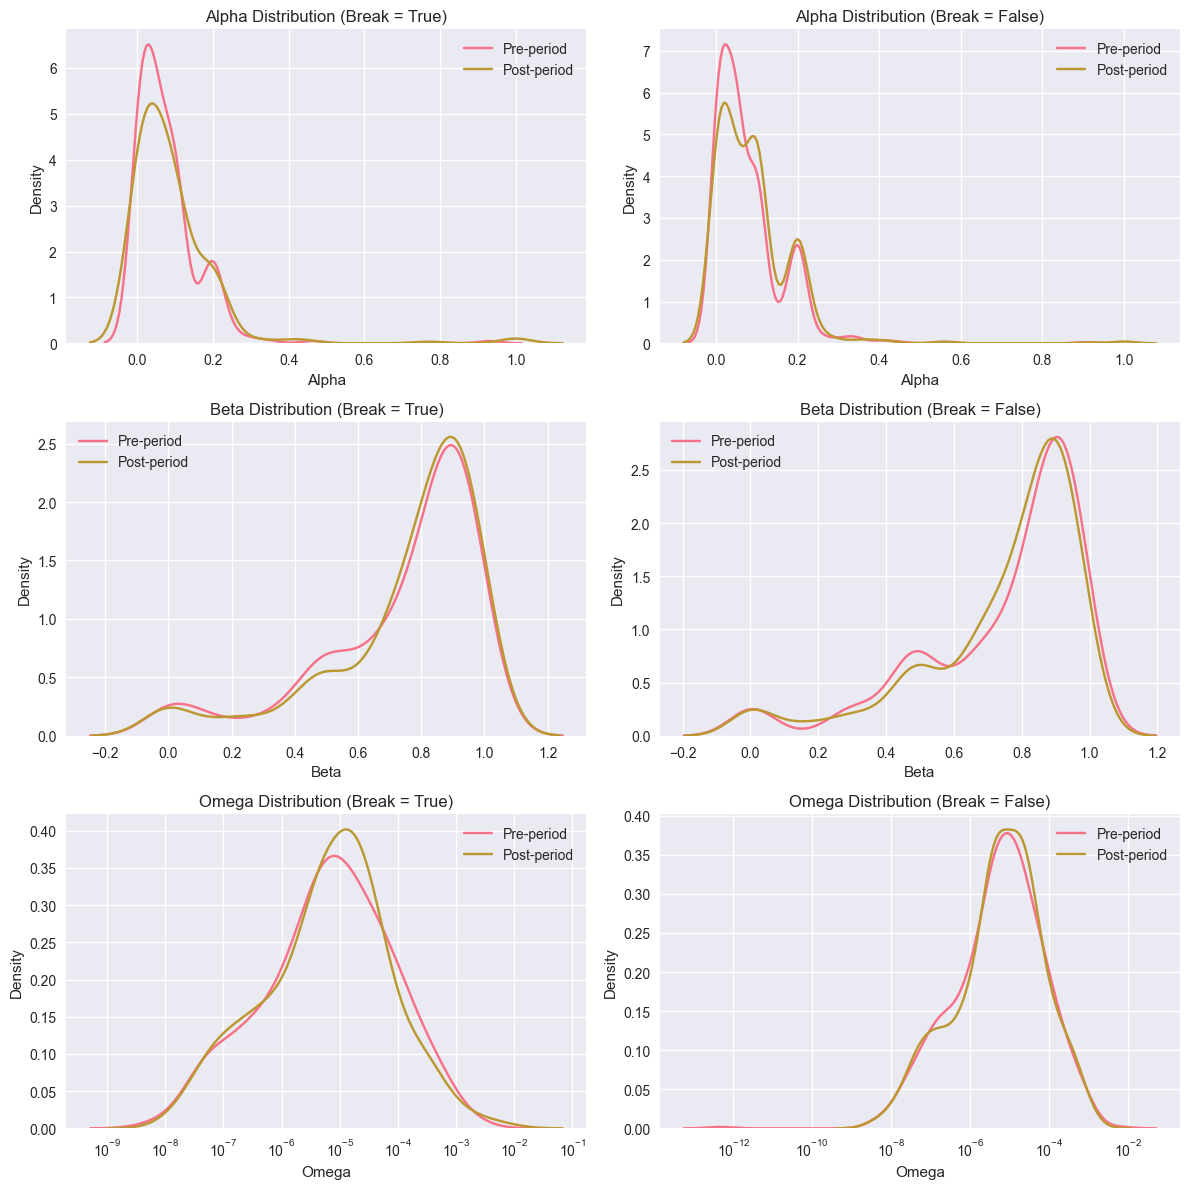

In [179]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=False)

# Split the DataFrame
df_break_true = df[df["break"] == True]
df_break_false = df[df["break"] == False]

# Column titles for clarity
col_titles = ["Break = True", "Break = False"]

# --- Alpha distributions ---
sns.kdeplot(df_break_true["alpha_pre"], label="Pre-period", ax=axes[0, 0])
sns.kdeplot(df_break_true["alpha_post"], label="Post-period", ax=axes[0, 0])
axes[0, 0].set_title(f"Alpha Distribution ({col_titles[0]})")
axes[0, 0].set_xlabel("Alpha")
axes[0, 0].set_ylabel("Density")
axes[0, 0].legend()

sns.kdeplot(df_break_false["alpha_pre"], label="Pre-period", ax=axes[0, 1])
sns.kdeplot(df_break_false["alpha_post"], label="Post-period", ax=axes[0, 1])
axes[0, 1].set_title(f"Alpha Distribution ({col_titles[1]})")
axes[0, 1].set_xlabel("Alpha")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()

# --- Beta distributions ---
sns.kdeplot(df_break_true["beta_pre"], label="Pre-period", ax=axes[1, 0])
sns.kdeplot(df_break_true["beta_post"], label="Post-period", ax=axes[1, 0])
axes[1, 0].set_title(f"Beta Distribution ({col_titles[0]})")
axes[1, 0].set_xlabel("Beta")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()

sns.kdeplot(df_break_false["beta_pre"], label="Pre-period", ax=axes[1, 1])
sns.kdeplot(df_break_false["beta_post"], label="Post-period", ax=axes[1, 1])
axes[1, 1].set_title(f"Beta Distribution ({col_titles[1]})")
axes[1, 1].set_xlabel("Beta")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()

# --- Omega distributions ---
sns.kdeplot(df_break_true["omega_pre"], label="Pre-period", ax=axes[2, 0], log_scale=True)
sns.kdeplot(df_break_true["omega_post"], label="Post-period", ax=axes[2, 0], log_scale=True)
axes[2, 0].set_title(f"Omega Distribution ({col_titles[0]})")
axes[2, 0].set_xlabel("Omega")
axes[2, 0].set_ylabel("Density")
axes[2, 0].legend()

sns.kdeplot(df_break_false["omega_pre"], label="Pre-period", ax=axes[2, 1], log_scale=True)
sns.kdeplot(df_break_false["omega_post"], label="Post-period", ax=axes[2, 1], log_scale=True)
axes[2, 1].set_title(f"Omega Distribution ({col_titles[1]})")
axes[2, 1].set_xlabel("Omega")
axes[2, 1].set_ylabel("Density")
axes[2, 1].legend()

plt.tight_layout()
plt.show()


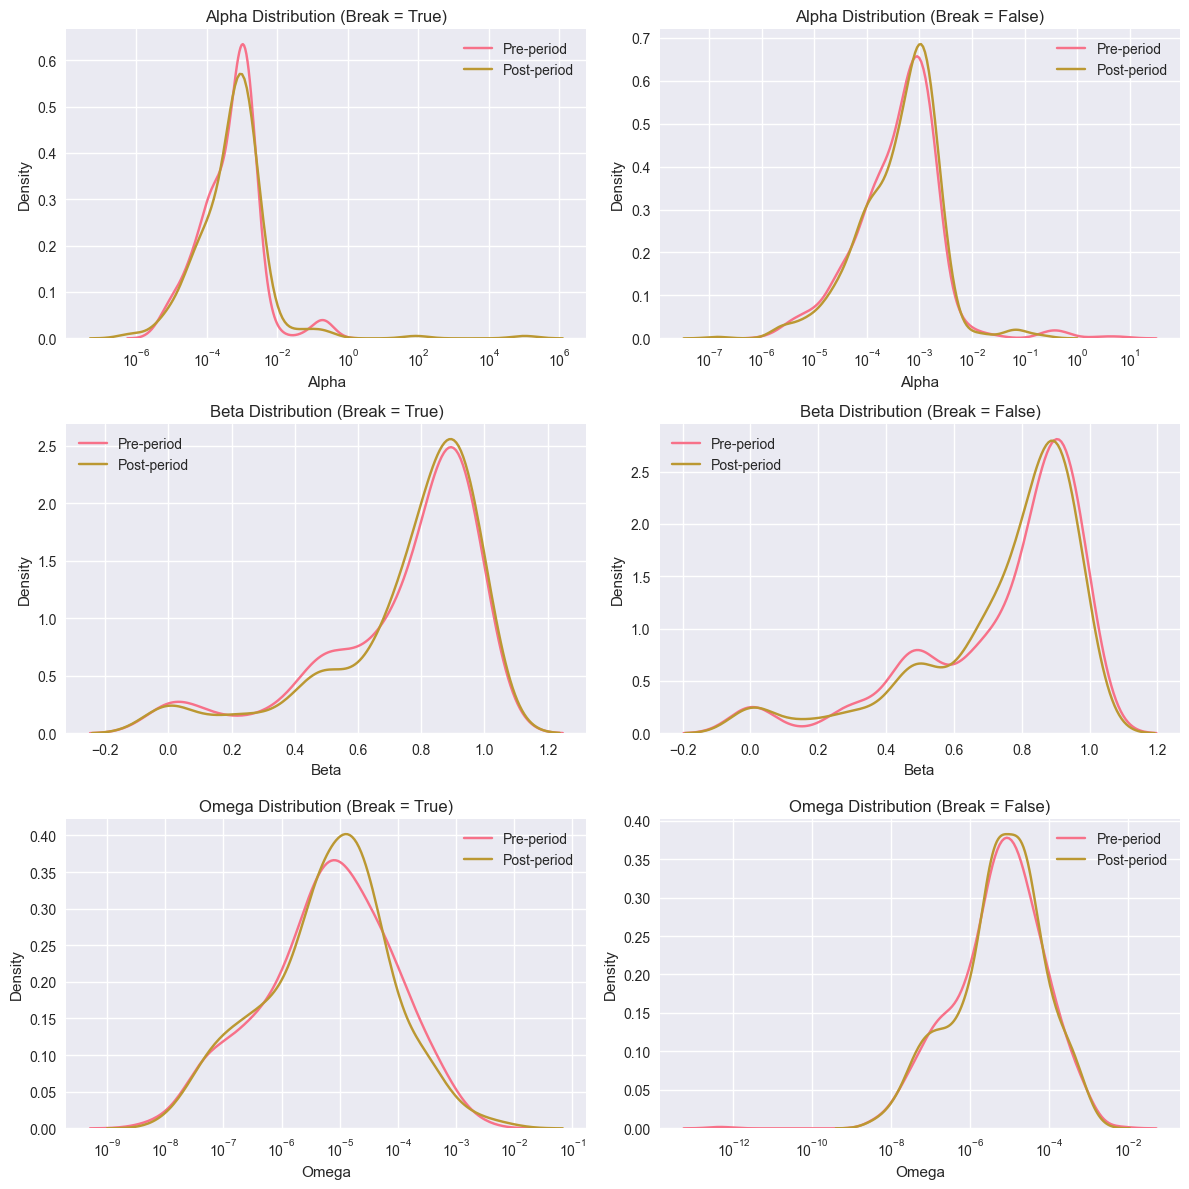

In [180]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=False)

# Split the DataFrame
df_break_true = df[df["break"] == True]
df_break_false = df[df["break"] == False]

# Column titles for clarity
col_titles = ["Break = True", "Break = False"]

# --- Alpha distributions ---
sns.kdeplot(df_break_true["intercept_pre"], label="Pre-period", ax=axes[0, 0], log_scale=10)
sns.kdeplot(df_break_true["intercept_post"], label="Post-period", ax=axes[0, 0], log_scale=10)
axes[0, 0].set_title(f"Alpha Distribution ({col_titles[0]})")
axes[0, 0].set_xlabel("Alpha")
axes[0, 0].set_ylabel("Density")
axes[0, 0].legend()

sns.kdeplot(df_break_false["intercept_pre"], label="Pre-period", ax=axes[0, 1], log_scale=10)
sns.kdeplot(df_break_false["intercept_post"], label="Post-period", ax=axes[0, 1], log_scale=10)
axes[0, 1].set_title(f"Alpha Distribution ({col_titles[1]})")
axes[0, 1].set_xlabel("Alpha")
axes[0, 1].set_ylabel("Density")
axes[0, 1].legend()

# --- Beta distributions ---
sns.kdeplot(df_break_true["beta_pre"], label="Pre-period", ax=axes[1, 0])
sns.kdeplot(df_break_true["beta_post"], label="Post-period", ax=axes[1, 0])
axes[1, 0].set_title(f"Beta Distribution ({col_titles[0]})")
axes[1, 0].set_xlabel("Beta")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()

sns.kdeplot(df_break_false["beta_pre"], label="Pre-period", ax=axes[1, 1])
sns.kdeplot(df_break_false["beta_post"], label="Post-period", ax=axes[1, 1])
axes[1, 1].set_title(f"Beta Distribution ({col_titles[1]})")
axes[1, 1].set_xlabel("Beta")
axes[1, 1].set_ylabel("Density")
axes[1, 1].legend()

# --- Omega distributions ---
sns.kdeplot(df_break_true["omega_pre"], label="Pre-period", ax=axes[2, 0], log_scale=True)
sns.kdeplot(df_break_true["omega_post"], label="Post-period", ax=axes[2, 0], log_scale=True)
axes[2, 0].set_title(f"Omega Distribution ({col_titles[0]})")
axes[2, 0].set_xlabel("Omega")
axes[2, 0].set_ylabel("Density")
axes[2, 0].legend()

sns.kdeplot(df_break_false["omega_pre"], label="Pre-period", ax=axes[2, 1], log_scale=True)
sns.kdeplot(df_break_false["omega_post"], label="Post-period", ax=axes[2, 1], log_scale=True)
axes[2, 1].set_title(f"Omega Distribution ({col_titles[1]})")
axes[2, 1].set_xlabel("Omega")
axes[2, 1].set_ylabel("Density")
axes[2, 1].legend()

plt.tight_layout()
plt.show()


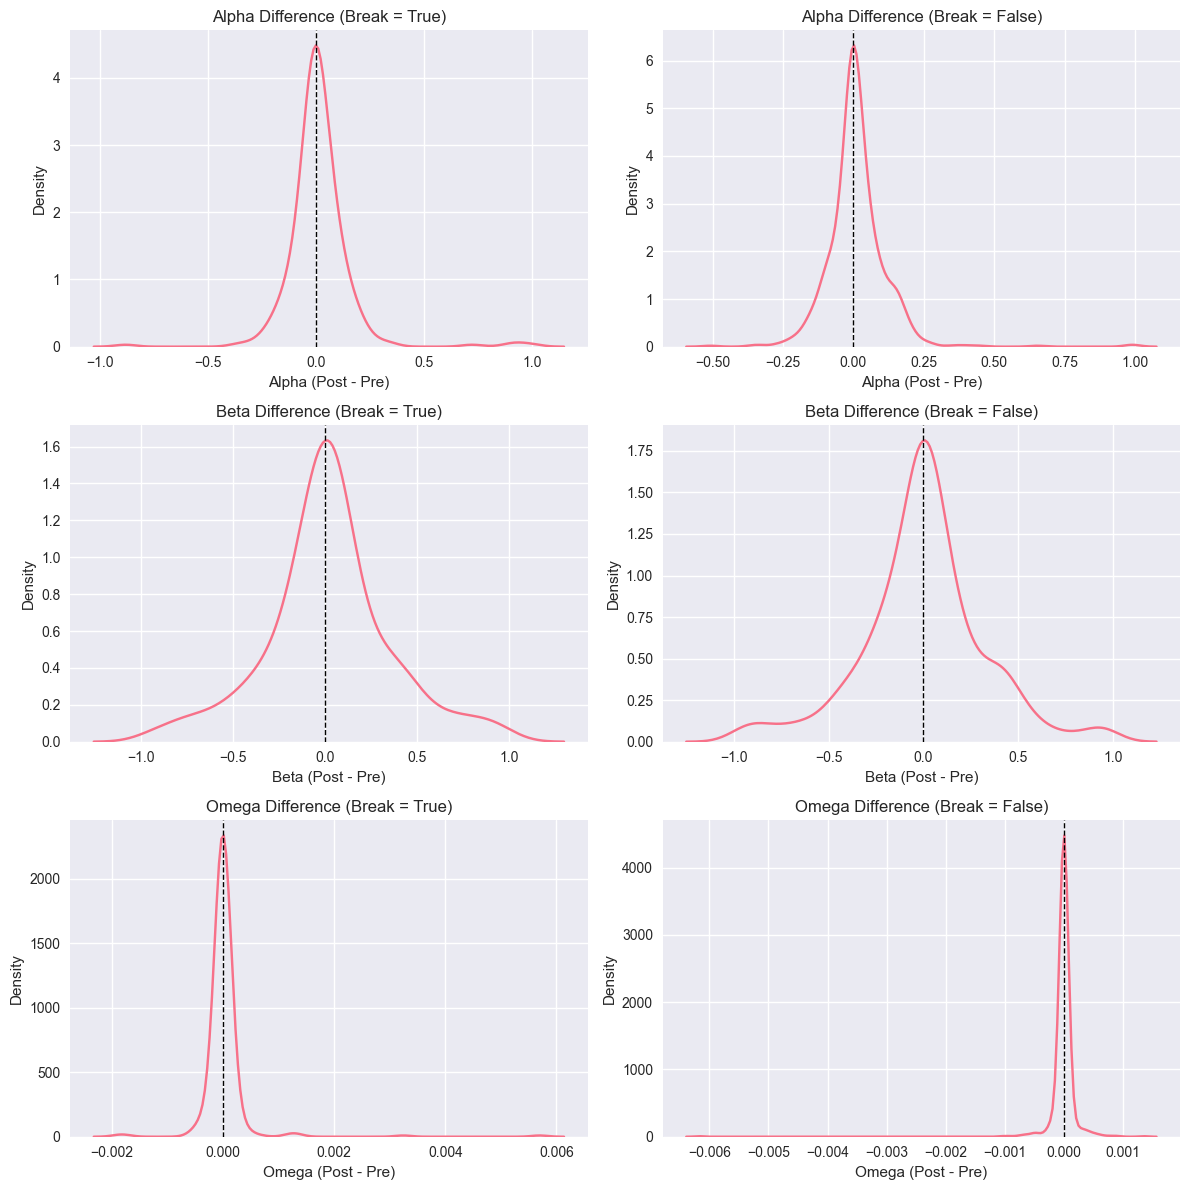

In [183]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=False)

# Split the DataFrame
df_break_true = df[df["break"] == True]
df_break_false = df[df["break"] == False]

# Column titles
col_titles = ["Break = True", "Break = False"]

# --- Alpha differences ---
sns.kdeplot(df_break_true["alpha_diff"], ax=axes[0, 0])
axes[0, 0].axvline(0, color="black", linestyle="--", linewidth=1)
axes[0, 0].set_title(f"Alpha Difference ({col_titles[0]})")
axes[0, 0].set_xlabel("Alpha (Post - Pre)")
axes[0, 0].set_ylabel("Density")

sns.kdeplot(df_break_false["alpha_diff"], ax=axes[0, 1])
axes[0, 1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[0, 1].set_title(f"Alpha Difference ({col_titles[1]})")
axes[0, 1].set_xlabel("Alpha (Post - Pre)")
axes[0, 1].set_ylabel("Density")

# --- Beta differences ---
sns.kdeplot(df_break_true["beta_diff"], ax=axes[1, 0])
axes[1, 0].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1, 0].set_title(f"Beta Difference ({col_titles[0]})")
axes[1, 0].set_xlabel("Beta (Post - Pre)")
axes[1, 0].set_ylabel("Density")

sns.kdeplot(df_break_false["beta_diff"], ax=axes[1, 1])
axes[1, 1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[1, 1].set_title(f"Beta Difference ({col_titles[1]})")
axes[1, 1].set_xlabel("Beta (Post - Pre)")
axes[1, 1].set_ylabel("Density")

# --- Omega differences ---
sns.kdeplot(df_break_true["omega_diff"], ax=axes[2, 0])
axes[2, 0].axvline(0, color="black", linestyle="--", linewidth=1)
axes[2, 0].set_title(f"Omega Difference ({col_titles[0]})")
axes[2, 0].set_xlabel("Omega (Post - Pre)")
axes[2, 0].set_ylabel("Density")

sns.kdeplot(df_break_false["omega_diff"], ax=axes[2, 1])
axes[2, 1].axvline(0, color="black", linestyle="--", linewidth=1)
axes[2, 1].set_title(f"Omega Difference ({col_titles[1]})")
axes[2, 1].set_xlabel("Omega (Post - Pre)")
axes[2, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()
